# PM2.5 Observations
## Group 6
### Nicholas Tam, Devansh Chopra, Steven Tsai, Xiao Jin

In [60]:
library(tidyverse)
library(testthat)
library(digest)
library(repr)
library(tidymodels)
library(cowplot)
library(GGally)
library(ISLR)

## Background Information
From 2010 to 2014, Beijing and a substantial part of China have suffered from chronic air pollution. The main pollutants are PM2.5, otherwise known as particulate matter, referring to tiny particles in the air with aerodynamic diameters of 2.5 micrometers (2.5 * 10^(-6) m or 2.5 μm) or less. (Inhalable Particulate Matter and Health (PM2.5 and PM10)) The presence of high concentrations of PM2.5 in Beijing from 2010 to 2014 has negatively influenced the climate, visibility, and human health. If PM2.5 concentration is exceptionally high, people suggest avoiding outdoor activities to reduce the risk of respiratory diseases. PM2.5 consists of a complex mixture of solids and aerosols, with particles containing various organic and inorganic compounds. Its concentration is highly influenced by meteorological conditions such as temperature and wind speed. (Sun, Ruiling, et al, 2019)

## Dataset and Project Question
For our research project, we have selected a dataset of hourly observations of PM2.5 concentration from 1-1-2010 to 12-31-2014. This dataset was retrieved from https://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data and contains the PM2.5 data of the US Embassy in Beijing, as well as the meteorological data from Beijing Capital International Airport. 

Our project question is: "Given surrounding temperatures, cululated wind speeds and relative humidity in differing months, can we predict the PM2.5 concentration in the air?" We will determine the strength of the relationships between the predictors and PM2.5 concentration. We expect the result to give us an insight into which situation is most optimal for outdoor activities in Beijing, such as hiking. 

We predict that:
- There will be a positive correlation between PM2.5 concentration and temperature, as an increase in temperature can affect the formation of particles, promoting photochemical reactions between precursors and leading to more PM2.5 being formed.
- There will be a negative correlation between PM2.5 concentration and wind speed, as PM2.5 will likely be more dispersed by the winds.
- There will be a negative correlation between PM2.5 concentration and humidity, as the particles will become too heavy to remain in the air, leading to dry and wet deposition, reducing the amount of PM2.5 in the air. 

## Graphs
We have read the dataset into R as shown below, including a new column for relative humidity called HUMID (%). HUMID is calculated by the formula HUMID = 100 - 5 * (TEMP - DEWP)), where TEMP is the observed temperature and DEWP is the dew point, the temperature the air needs to be cooled to (at constant pressure) in order to achieve a relative humidity of 100%. 

In [61]:
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00381/PRSA_data_2010.1.1-2014.12.31.csv"
pollution <- read_csv(url)
pollution <- na.omit(pollution)
# pollution[is.na(pollution)] <- 0
pollution <- mutate(pollution, HUMID = 100 - 5 * (TEMP - DEWP))
head(pollution)

Parsed with column specification:
cols(
  No = col_double(),
  year = col_double(),
  month = col_double(),
  day = col_double(),
  hour = col_double(),
  pm2.5 = col_double(),
  DEWP = col_double(),
  TEMP = col_double(),
  PRES = col_double(),
  cbwd = col_character(),
  Iws = col_double(),
  Is = col_double(),
  Ir = col_double()
)



No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir,HUMID
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
25,2010,1,2,0,129,-16,-4,1020,SE,1.79,0,0,40
26,2010,1,2,1,148,-15,-4,1020,SE,2.68,0,0,45
27,2010,1,2,2,159,-11,-5,1021,SE,3.57,0,0,70
28,2010,1,2,3,181,-7,-5,1022,SE,5.36,1,0,90
29,2010,1,2,4,138,-7,-5,1022,SE,6.25,2,0,90
30,2010,1,2,5,109,-7,-6,1022,SE,7.14,3,0,95


### Data Splitting
We take the averages of each of our chosen variables to allow a visualisation of all of our data and make the interpretation of the data to be easier. This will be used separately from the training and testing data.

We chose to include two variables that are more familiar to the readers, temperature (TEMP) and relative humidity (HUMID). Since the dew point (DEWP) can be derived from temperature and humidity, we decide to remove DEWP. We have removed combined wind direction (cbwd) due to not being a quantitative variable, and there are several studies claiming that PM2.5 concentration has a weak correlation with wind direction, while the day and hour columns are too precise to be relevant to the data. Pressure (PRES) is removed due to being an environmental quality that is not as noticable as the predictors we are using. Cumulated hours of snow (Is) and rain (Ir) are also removed, as they do not change drastically and frequently enough to be usable, with Is and Ir being limited by the number of snow and rain days across the years respectively. 

In [104]:
options(repr.matrix.max.rows = 12)
pollute_avg <- pollution %>%
     select(year, month, day, hour, pm2.5, DEWP, TEMP, Iws, HUMID) %>%
     group_by(year,month) %>%
     summarise(pm2.5_avg = mean(pm2.5, na.rm = TRUE),TEMP_avg = mean(TEMP, na.rm = TRUE),Iws_avg = mean(Iws, na.rm = TRUE), HUMID_avg = mean(HUMID, na.rm = TRUE))
pollute_avg

pollution_vals <- pollution %>%
    select(pm2.5, TEMP, Iws, HUMID) %>%
    as_tibble()
pollution_vals

pollution_split <- initial_split(pollution_vals, prop = 3/4, strata = pm2.5)
pollution_training <- training(pollution_split)
pollution_testing <- testing(pollution_split)

`summarise()` regrouping output by 'year' (override with `.groups` argument)



year,month,pm2.5_avg,TEMP_avg,Iws_avg,HUMID_avg
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2010,1,90.44257,-6.364472,39.381133,47.94028
2010,2,97.23398,-1.918033,13.482191,43.81520
2010,3,94.10014,2.983075,24.122863,42.03103
2010,4,80.02925,10.805014,58.074666,29.51950
2010,5,86.89959,20.856174,21.602564,33.62280
2010,6,109.00354,24.458407,9.553717,59.45133
⋮,⋮,⋮,⋮,⋮,⋮
2014,7,89.45590,28.004071,18.363921,56.33650
2014,8,62.94270,25.750341,7.413847,60.67531


pm2.5,TEMP,Iws,HUMID
<dbl>,<dbl>,<dbl>,<dbl>
129,-4,1.79,40
148,-4,2.68,45
159,-5,3.57,70
181,-5,5.36,90
138,-5,6.25,90
109,-6,7.14,95
⋮,⋮,⋮,⋮
10,-2,226.16,0
8,-2,231.97,-5


### Graphs of Weather Data
In our data, we use TEMP (Surrounding temperature, °C), Iws (Cumulated wind speed, m/s), and HUMID (Relative humidity, %) as three predictors to predict our outcome variable, pm2.5 (PM2.5, ug/m^3). We generate three graphs: 
- A matrix of graphs between all the variables using training data
- A scatterplot against pm2.5 using the average TEMP, Iws, and HUMID values of each month to visualise the relationship of all three predictors against pm2.5
- A bar graph of ranges of TEMP, Iws, and HUMID and the corresponding average pm2.5 of each range
This is done such that we can see the relationship of all three predictors against pm2.5. A regression line is also drawn for each scatterplot to interpret the relationships further. 

This graph is a matrix of graphs between all the variables using training data, showing the correlation between each variable. As displayed in the graph, there is a stronger correlation between HUMID and pm2.5 than TEMP and Iws with pm2.5. pm2.5 has a positive relationship with HUMID and a negative relationship with TEMP and Iws, with TEMP having a weaker relationship with pm2.5.

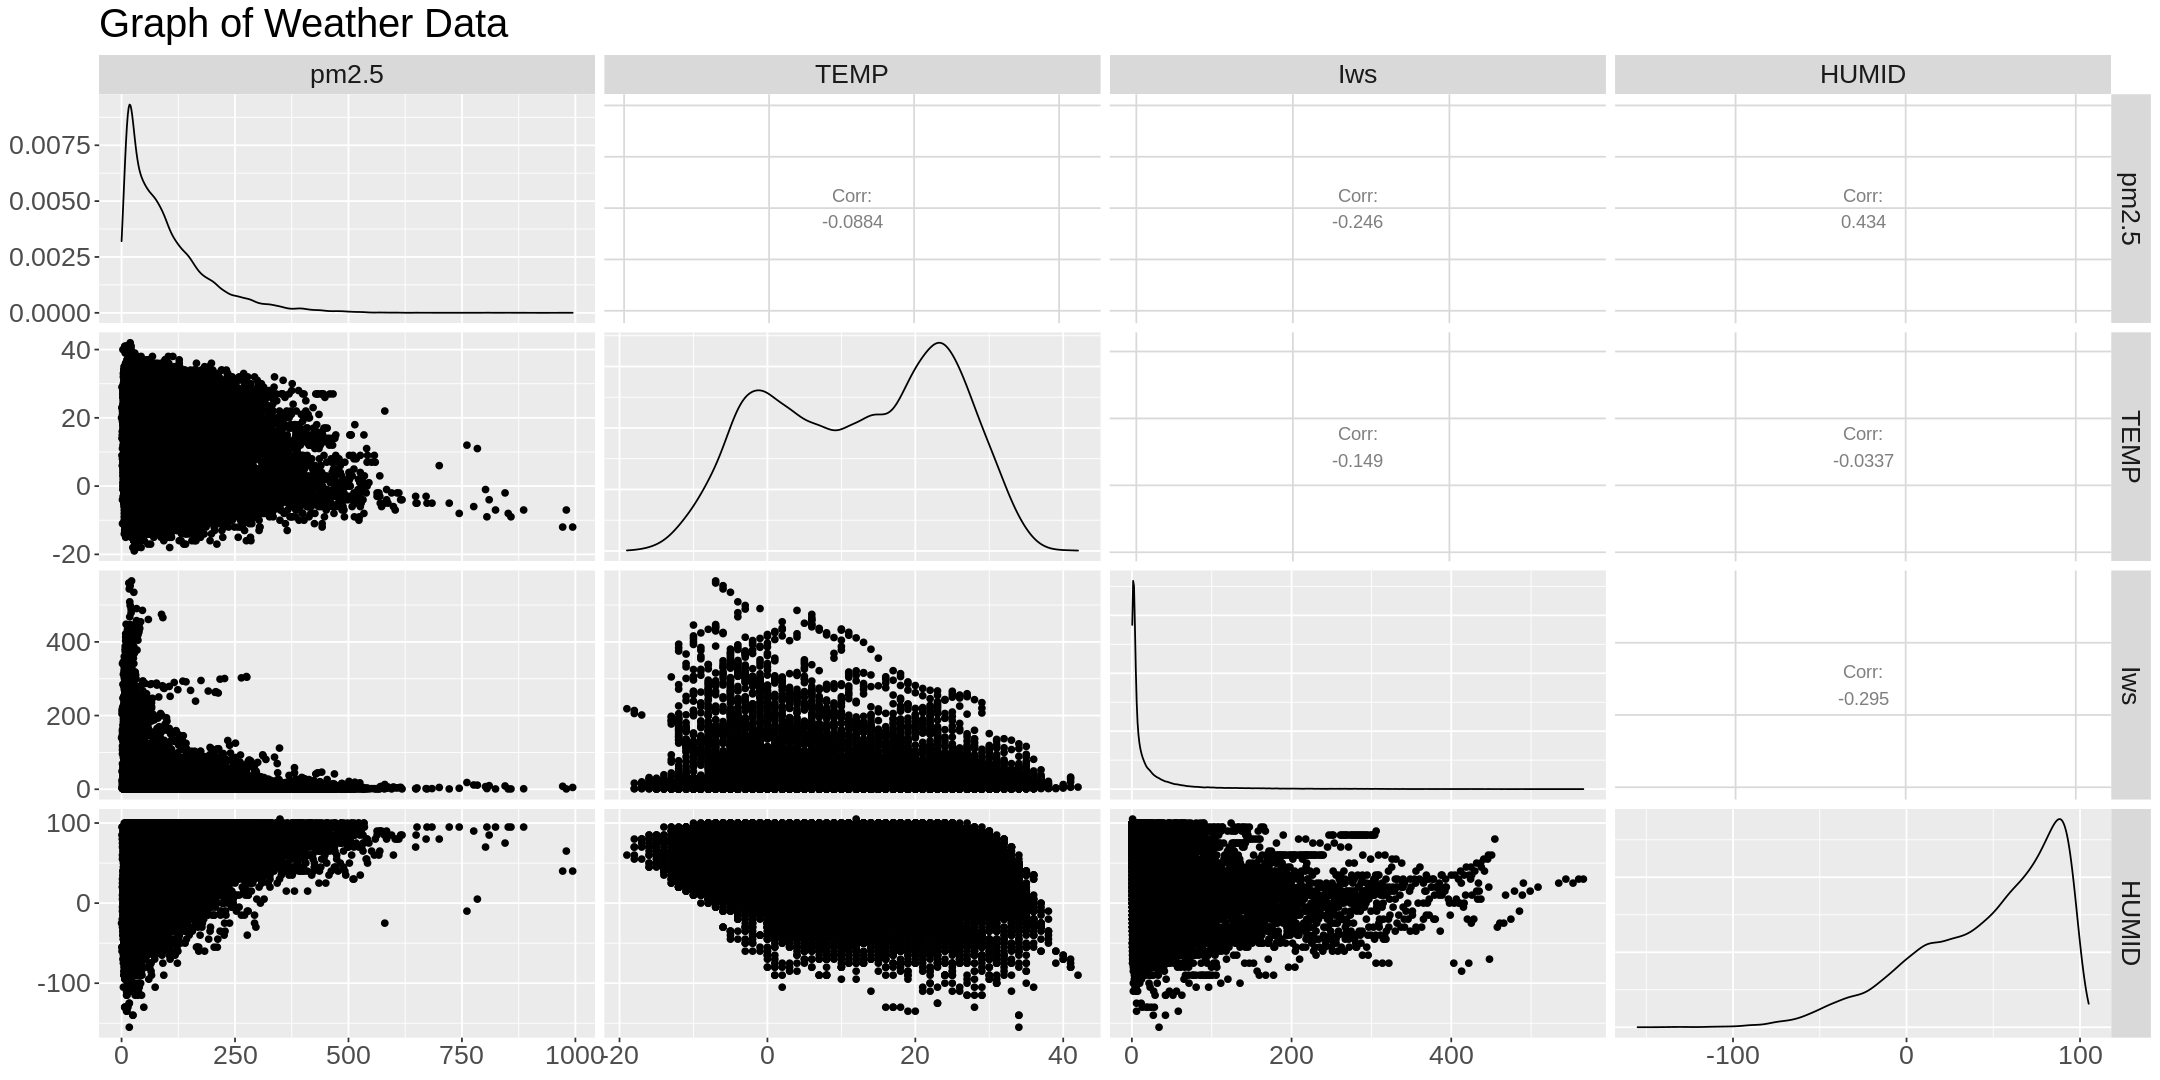

In [105]:
set.seed(9999)
ggpairs(data = pollution_training) +
    labs(title = "Graph of Weather Data") + 
    theme(text = element_text(size = 20))

We fit a linear regression model using tidymodels with pollution_training using all variables in the dataset, by creating the following:
- Model specification called lm-spec
- Recipe called lm_recipe
- Workflow and model fit called lm_fit

To evaluate the effectiveness of our model, we 

In [106]:
set.seed(9999)
lm_spec <- linear_reg() %>%
  set_engine("lm") %>%
  set_mode("regression")
lm_spec
lm_recipe <- recipe(pm2.5 ~ TEMP+Iws+HUMID, data = pollution_training)
lm_recipe
lm_fit <- workflow() %>%
  add_recipe(lm_recipe) %>%
  add_model(lm_spec) %>%
  fit(data = pollution_training)
lm_fit
lm_rmse <- lm_fit %>%
        predict(pollution_training) %>%
        bind_cols(pollution_training) %>%
        metrics(truth = pm2.5, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
lm_rmse
lm_rmspe <- lm_fit %>%
        predict(pollution_testing) %>%
        bind_cols(pollution_testing) %>%
        metrics(truth = pm2.5, estimate = .pred) %>%
         filter(.metric == "rmse") %>%
         select(.estimate) %>%
         pull()
lm_rmspe

Linear Regression Model Specification (regression)

Computational engine: lm 


Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor          3

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
(Intercept)         TEMP          Iws        HUMID  
    73.4458      -0.7351      -0.2720       0.8711  


[1] 81.74949

[1] 80.77419

### Graphs of PM2.5 against Temperature
The plots below display the scatter plot and bar plot of PM2.5 concentration against temperature based on the data from the years 2010 to 2014, using the average temperatures of each month. In general, there is a moderately steady decrease in the PM2.5 concentration as the temperature increases, implying a negative relationship between the variables within this data set. This negative relationship is moderately weak (the data points are not too clustered around the fitted line) and linear, and there are more extreme outliers when the temperature is low (<= 0 approximately).

`geom_smooth()` using formula 'y ~ x'

`summarise()` ungrouping output (override with `.groups` argument)



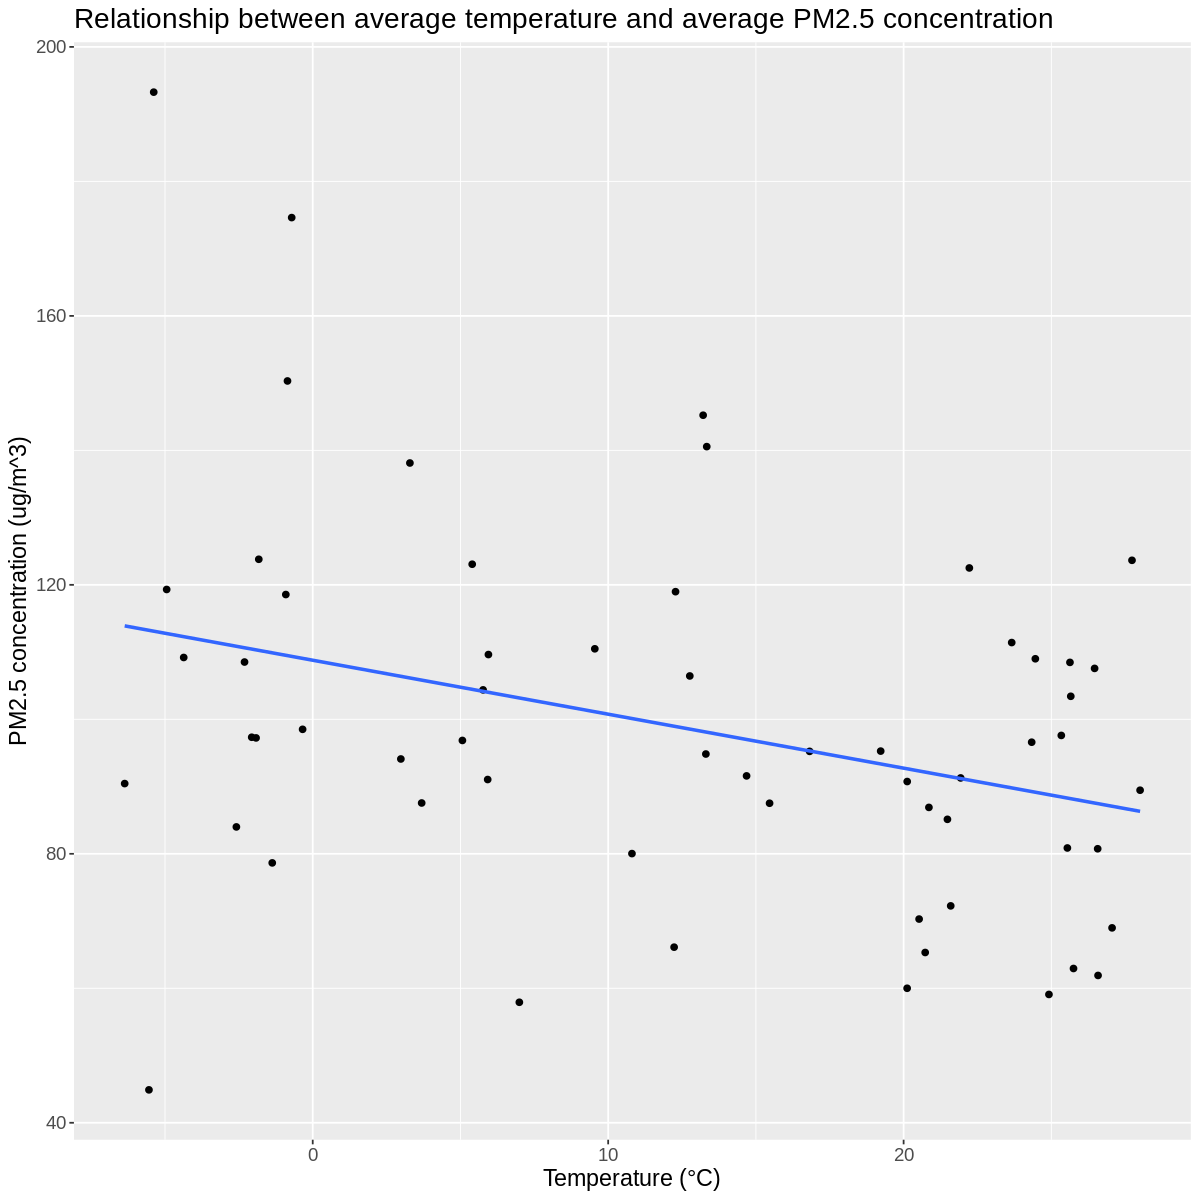

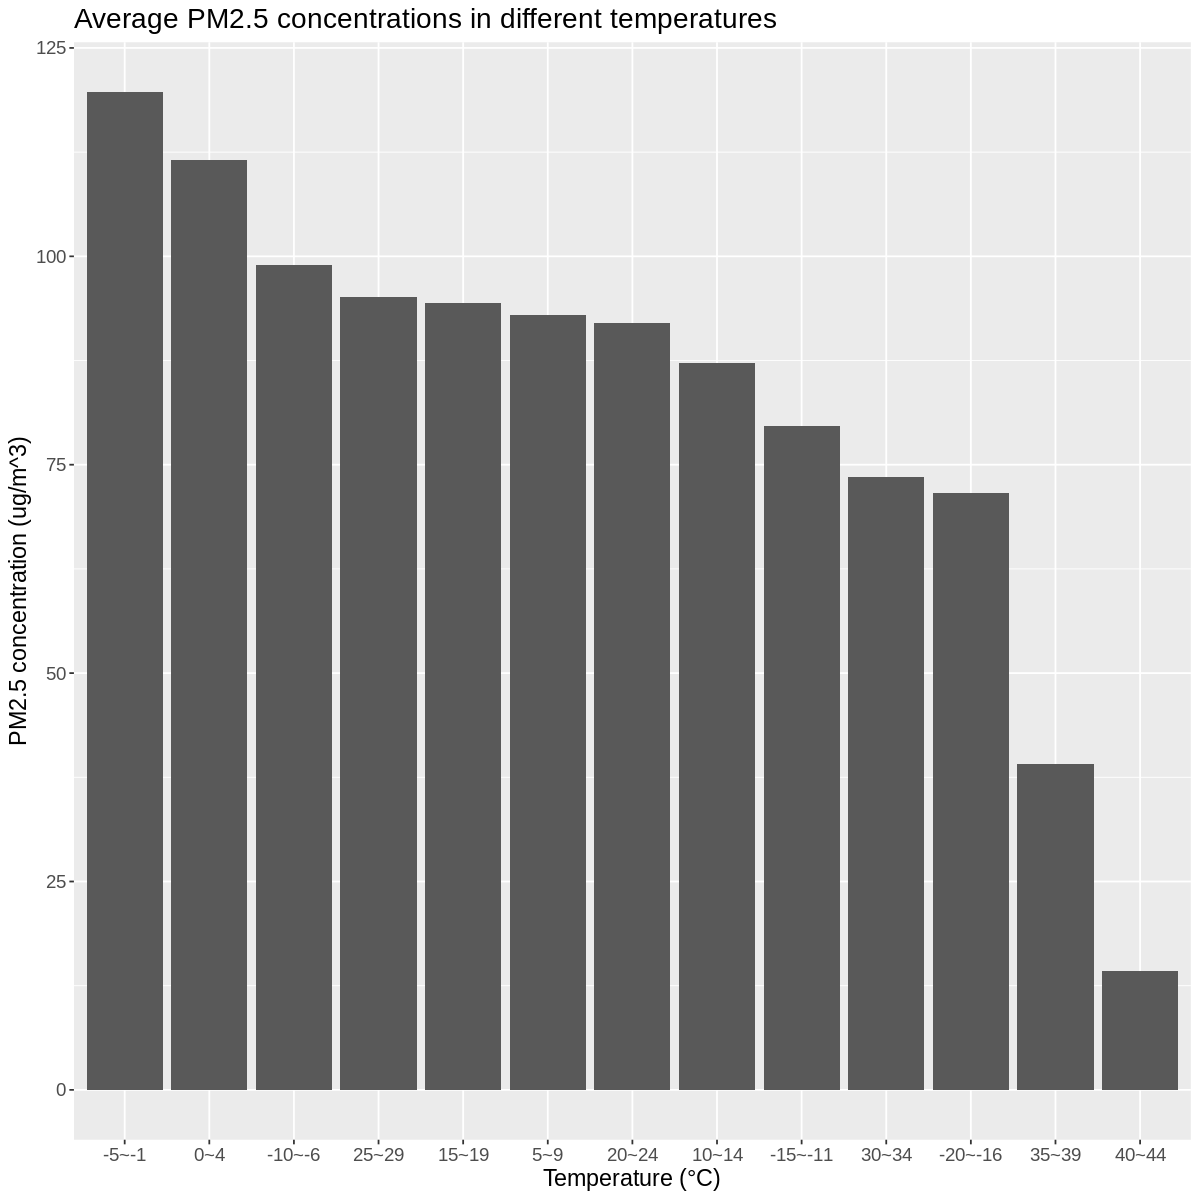

In [107]:
set.seed(9999)
options(repr.plot.width = 10, repr.plot.height = 10)

TEMP_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = TEMP_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method = "lm", se = FALSE) +
ggtitle("Relationship between average temperature and average PM2.5 concentration") +
labs(x = "Temperature (°C)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
TEMP_pm2.5_avg_plot

temp.dat = pollution_training %>%
    group_by(TEMP) %>%
    summarize(pm2.5_avg = mean(pm2.5,na.rm=TRUE))

temp.col1 = temp.dat %>%
    filter(TEMP >= -20,TEMP < -15) %>%
    select(pm2.5_avg)
col.val1 = sum(temp.col1)/nrow(temp.col1)
temp.col2 = temp.dat %>%
    filter(TEMP >= -15,TEMP < -10) %>%
    select(pm2.5_avg)
col.val2 = sum(temp.col2)/nrow(temp.col2)
temp.col3 = temp.dat %>%
    filter(TEMP >= -10,TEMP < -5) %>%
    select(pm2.5_avg)
col.val3 = sum(temp.col3)/nrow(temp.col3)
temp.col4 = temp.dat %>%
    filter(TEMP >= -5,TEMP < 0) %>%
    select(pm2.5_avg)
col.val4 = sum(temp.col4)/nrow(temp.col4)
temp.col5 = temp.dat %>%
    filter(TEMP >= 0,TEMP < 5) %>%
    select(pm2.5_avg)
col.val5 = sum(temp.col5)/nrow(temp.col5)
temp.col6 = temp.dat %>%
    filter(TEMP >= 5,TEMP < 10) %>%
    select(pm2.5_avg)
col.val6 = sum(temp.col6)/nrow(temp.col6)
temp.col7 = temp.dat %>%
    filter(TEMP >= 10,TEMP < 15) %>%
    select(pm2.5_avg)
col.val7 = sum(temp.col7)/nrow(temp.col7)
temp.col8 = temp.dat %>%
    filter(TEMP >= 15,TEMP < 20) %>%
    select(pm2.5_avg)
col.val8 = sum(temp.col8)/nrow(temp.col8)
temp.col9 = temp.dat %>%
    filter(TEMP >= 20,TEMP < 25) %>%
    select(pm2.5_avg)
col.val9 = sum(temp.col9)/nrow(temp.col9)
temp.col10 = temp.dat %>%
    filter(TEMP >= 25,TEMP < 30) %>%
    select(pm2.5_avg)
col.val10 = sum(temp.col10)/nrow(temp.col10)
temp.col11 = temp.dat %>%
    filter(TEMP >= 30,TEMP < 35) %>%
    select(pm2.5_avg)
col.val11 = sum(temp.col11)/nrow(temp.col11)
temp.col12 = temp.dat %>%
    filter(TEMP >= 35,TEMP < 40) %>%
    select(pm2.5_avg)
col.val12 = sum(temp.col12)/nrow(temp.col12)
temp.col13 = temp.dat %>%
    filter(TEMP >= 40,TEMP < 45) %>%
    select(pm2.5_avg)
col.val13 = sum(temp.col13)/nrow(temp.col13)
temp.name = c("-20~-16","-15~-11","-10~-6","-5~-1","0~4","5~9","10~14","15~19","20~24","25~29","30~34","35~39","40~44")
temp.plot.data = data.frame(temp.name,c(col.val1,col.val2,col.val3,col.val4,col.val5,col.val6,col.val7,col.val8,col.val9,col.val10,col.val11,col.val12,col.val13))
colnames(temp.plot.data) = c("temp.range","pm2.5.avg")

TEMP_pm2.5_bar_plot <- ggplot(temp.plot.data,aes(x=reorder(temp.range,-pm2.5.avg),y=pm2.5.avg)) +
geom_bar(stat="identity") +
ggtitle("Average PM2.5 concentrations in different temperatures") +
labs(x = "Temperature (°C)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
TEMP_pm2.5_bar_plot

`geom_smooth()` using formula 'y ~ x'

`summarise()` ungrouping output (override with `.groups` argument)

`summarise()` ungrouping output (override with `.groups` argument)



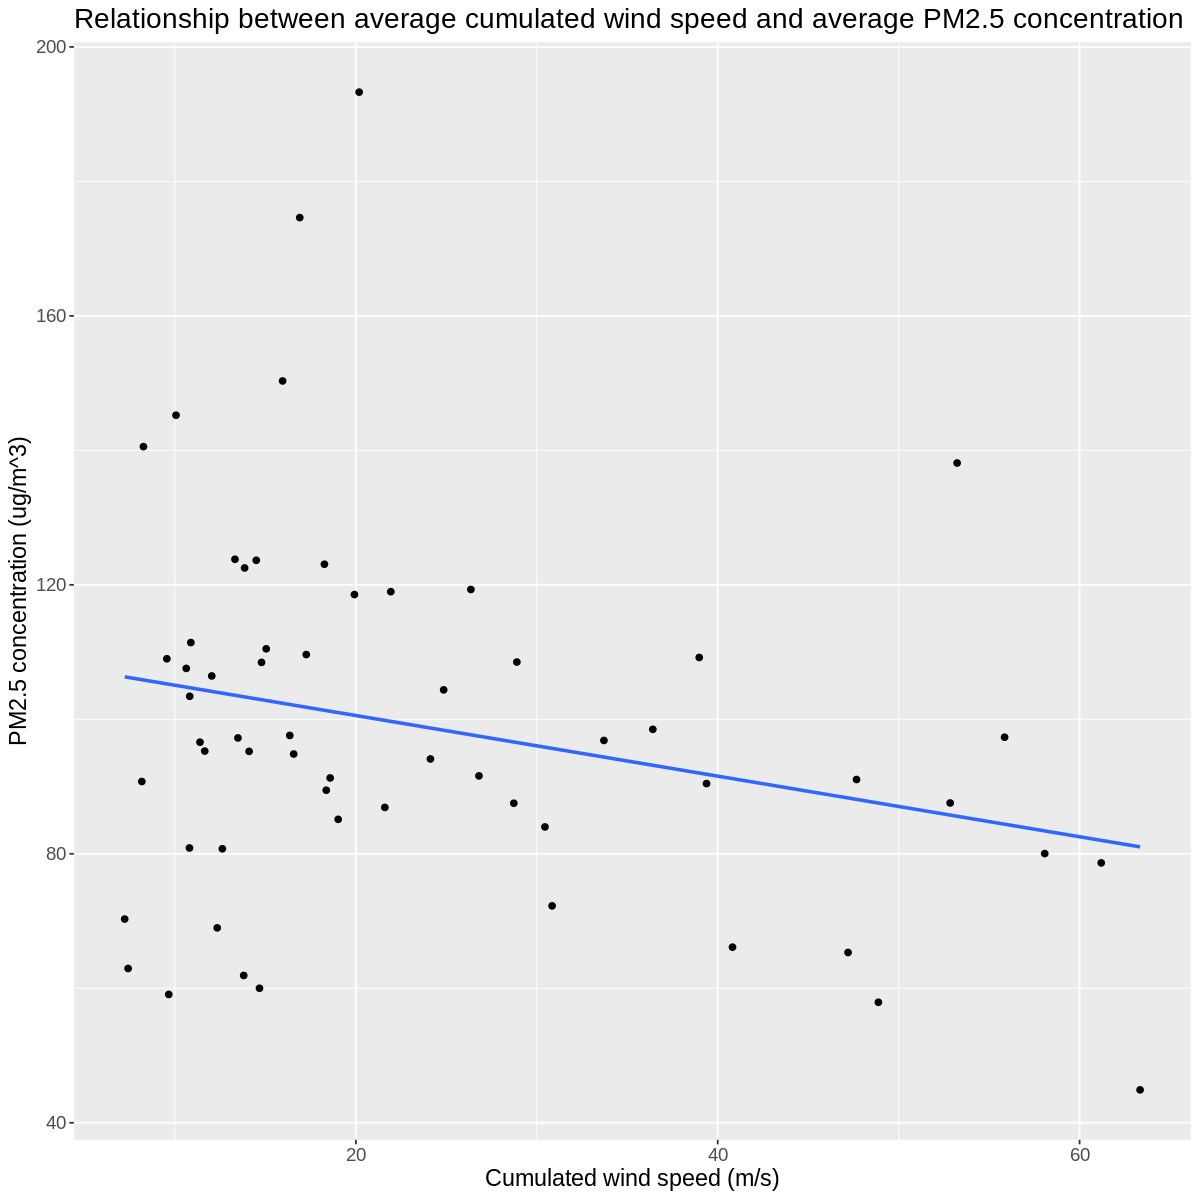

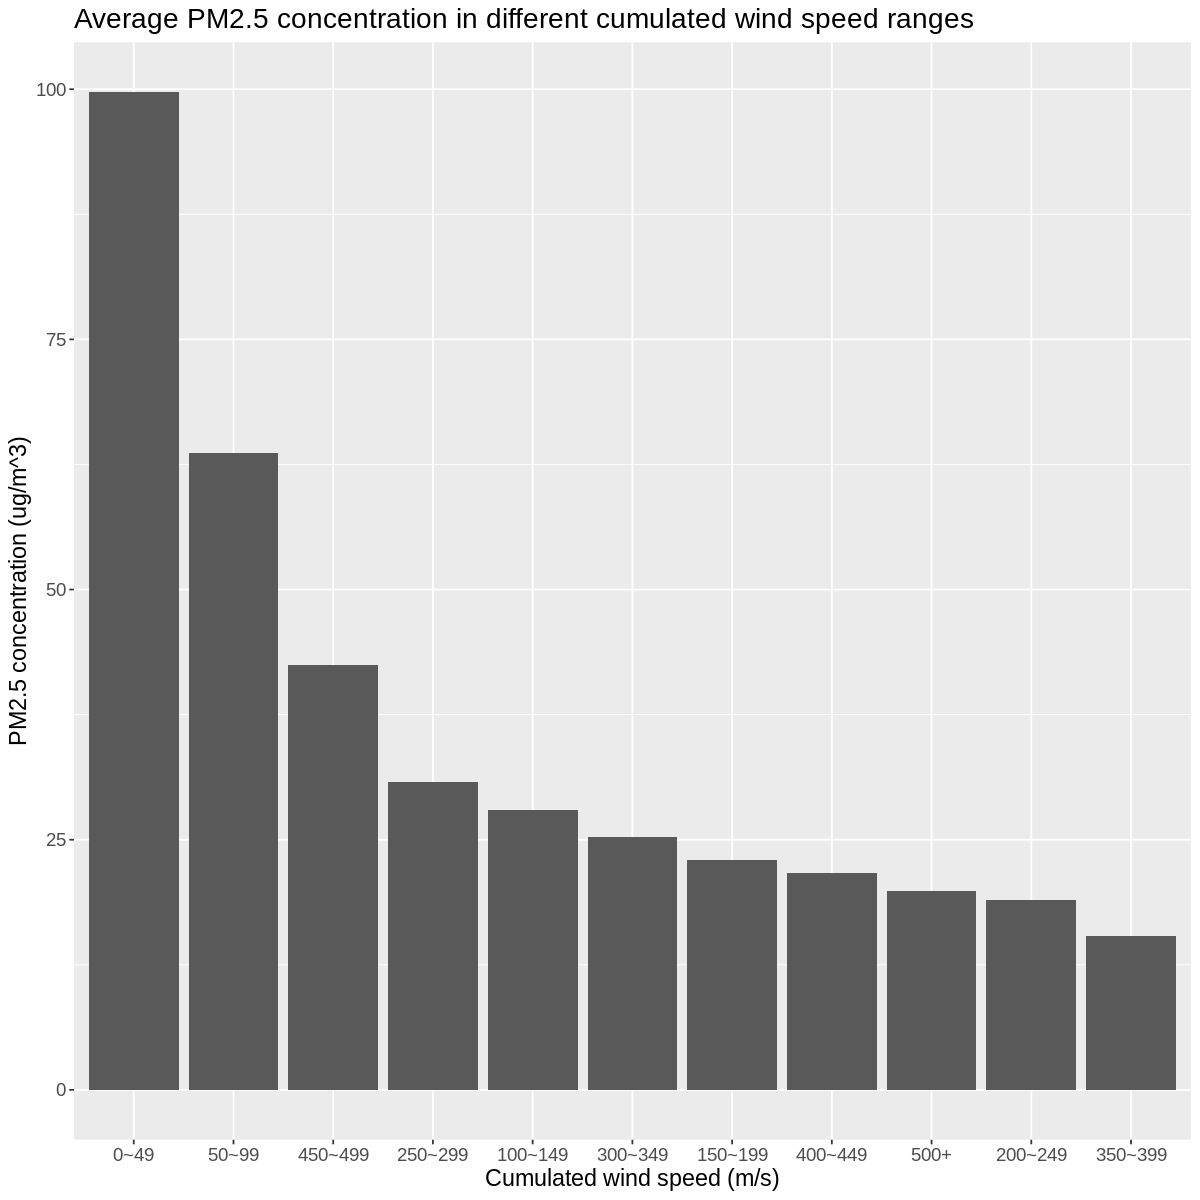

In [108]:
set.seed(9999)
options(repr.plot.width = 10, repr.plot.height = 10)

Iws_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = Iws_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method = "lm", se = FALSE) +
ggtitle("Relationship between average cumulated wind speed and average PM2.5 concentration") + 
labs(x = "Cumulated wind speed (m/s)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
Iws_pm2.5_avg_plot

ws.dat = pollution_training %>%
    group_by(Iws) %>%
    summarize(pm2.5_avg = mean(pm2.5,na.rm=TRUE))
colnames(ws.dat) = c("Iws","pm2.5_avg")
ws.dat = pollution_training %>%
    group_by(Iws) %>%
    summarize(pm2.5_avg = mean(pm2.5,na.rm=TRUE))
ws.col1 = ws.dat %>%
    filter(Iws >= 0,Iws < 50) %>%
    select(pm2.5_avg)
ws.val1 = sum(ws.col1)/nrow(ws.col1)
ws.col2 = ws.dat %>%
    filter(Iws >= 50,Iws < 100) %>%
    select(pm2.5_avg)
ws.val2 = sum(ws.col2)/nrow(ws.col2)
ws.col3 = ws.dat %>%
    filter(Iws >= 100,Iws < 150) %>%
    select(pm2.5_avg)
ws.val3 = sum(ws.col3)/nrow(ws.col3)
ws.col4 = ws.dat %>%
    filter(Iws >= 150,Iws < 200) %>%
    select(pm2.5_avg)
ws.val4 = sum(ws.col4)/nrow(ws.col4)
ws.col5 = ws.dat %>%
    filter(Iws >= 200,Iws < 250) %>%
    select(pm2.5_avg)
ws.val5 = sum(ws.col5)/nrow(ws.col5)
ws.col6 = ws.dat %>%
    filter(Iws >= 250,Iws < 300) %>%
    select(pm2.5_avg)
ws.val6 = sum(ws.col6)/nrow(ws.col6)
ws.col7 = ws.dat %>%
    filter(Iws >= 300,Iws < 350) %>%
    select(pm2.5_avg)
ws.val7 = sum(ws.col7)/nrow(ws.col7)
ws.col8 = ws.dat %>%
    filter(Iws >= 350,Iws < 400) %>%
    select(pm2.5_avg)
ws.val8 = sum(ws.col8)/nrow(ws.col8)
ws.col9 = ws.dat %>%
    filter(Iws >= 400,Iws < 450) %>%
    select(pm2.5_avg)
ws.val9 = sum(ws.col9)/nrow(ws.col9)
ws.col10 = ws.dat %>%
    filter(Iws >= 450,Iws < 500) %>%
    select(pm2.5_avg)
ws.val10 = sum(ws.col10)/nrow(ws.col10)
ws.col11 = ws.dat %>%
    filter(Iws >= 500) %>%
    select(pm2.5_avg)
ws.val11 = sum(ws.col11)/nrow(ws.col11)
ws.name = c("0~49","50~99","100~149","150~199","200~249","250~299","300~349","350~399","400~449","450~499","500+")
ws.plot.data = data.frame(ws.name,c(ws.val1,ws.val2,ws.val3,ws.val4,ws.val5,ws.val6,ws.val7,ws.val8,ws.val9,ws.val10,ws.val11))
colnames(ws.plot.data) = c("ws.range","pm2.5.avg")

Iws_pm2.5_bar_plot <- ggplot(ws.plot.data,aes(x=reorder(ws.range,-pm2.5.avg),y=pm2.5.avg)) +
geom_bar(stat="identity") +
ggtitle("Average PM2.5 concentration in different cumulated wind speed ranges") +
labs(x = "Cumulated wind speed (m/s)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
Iws_pm2.5_bar_plot

The plots above display the scatter plot and bar plot of PM2.5 concentration against cumulated wind speed based on the data from the years 2010 to 2014, using the average cumulated wind speed of each month. Overall, there is a moderately steady decrease in PM2.5 concentration when the cumulated wind speed increases. This indicates that there is a negative relationship between these variables within this data set. This negative relationship is moderately weak (the data points are not too clustered around the fitted line) and linear. Also, the data points are clustered when the cumulated wind speed is small and the variation in PM2.5 concentration is larger when the cumulated wind speed is greater. Meanwhile, there are several noticeable outliers when the cumulated wind speed is small (<= 20 approximately).

`geom_smooth()` using formula 'y ~ x'

`summarise()` ungrouping output (override with `.groups` argument)



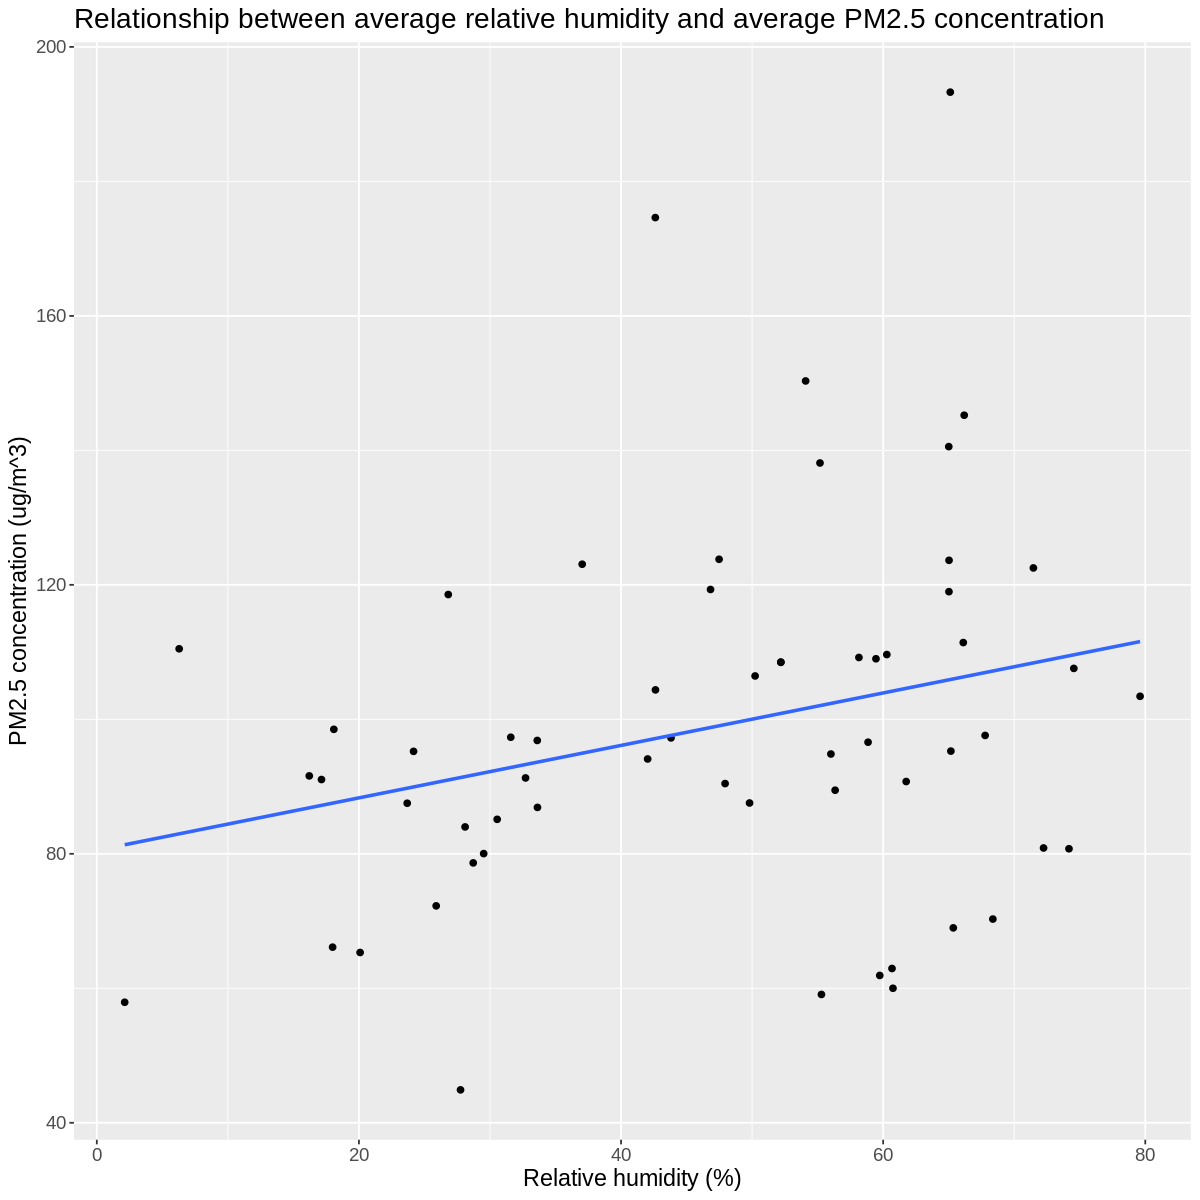

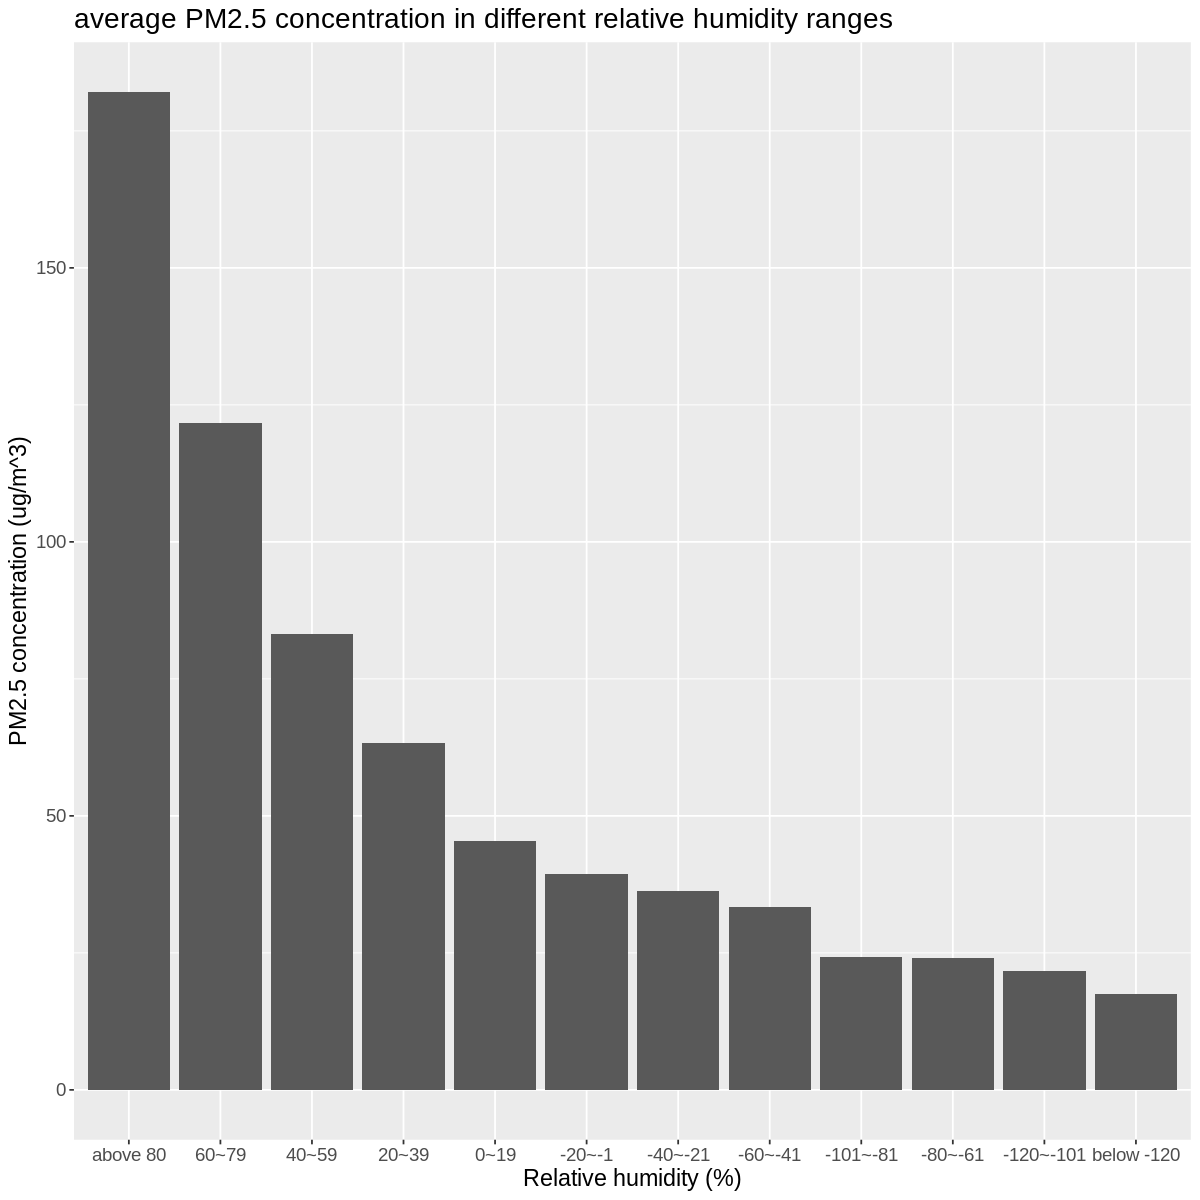

In [109]:
set.seed(9999)
options(repr.plot.width = 10, repr.plot.height = 10)

HUMID_pm2.5_avg_plot <- ggplot(pollute_avg, aes(x = HUMID_avg,y = pm2.5_avg)) +
geom_point() +
geom_smooth(method = "lm", se = FALSE) +
ggtitle("Relationship between average relative humidity and average PM2.5 concentration") + 
labs(x = "Relative humidity (%)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
HUMID_pm2.5_avg_plot

hu.dat = pollution %>%
    group_by(HUMID) %>%
    summarize(pm2.5_avg = mean(pm2.5,na.rm=TRUE))
hu.col1 = hu.dat %>%
    filter(HUMID < -120) %>%
    select(pm2.5_avg)
hu.val1 = sum(hu.col1)/nrow(hu.col1)
hu.col2 = hu.dat %>%
    filter(HUMID >= -120,HUMID < -100) %>%
    select(pm2.5_avg)
hu.val2 = sum(hu.col2)/nrow(hu.col2)
hu.col3 = hu.dat %>%
    filter(HUMID >= -100,HUMID < -80) %>%
    select(pm2.5_avg)
hu.val3 = sum(hu.col3)/nrow(hu.col3)
hu.col4 = hu.dat %>%
    filter(HUMID >= -80,HUMID < -60) %>%
    select(pm2.5_avg)
hu.val4 = sum(hu.col4)/nrow(hu.col4)
hu.col5 = hu.dat %>%
    filter(HUMID >= -60,HUMID < -40) %>%
    select(pm2.5_avg)
hu.val5 = sum(hu.col5)/nrow(hu.col5)
hu.col6 = hu.dat %>%
    filter(HUMID >= -40,HUMID < -20) %>%
    select(pm2.5_avg)
hu.val6 = sum(hu.col6)/nrow(hu.col6)
hu.col7 = hu.dat %>%
    filter(HUMID >= -20,HUMID < 0) %>%
    select(pm2.5_avg)
hu.val7 = sum(hu.col7)/nrow(hu.col7)
hu.col8 = hu.dat %>%
    filter(HUMID >= 0,HUMID < 20) %>%
    select(pm2.5_avg)
hu.val8 = sum(hu.col8)/nrow(hu.col8)
hu.col9 = hu.dat %>%
    filter(HUMID >= 20,HUMID < 40) %>%
    select(pm2.5_avg)
hu.val9 = sum(hu.col9)/nrow(hu.col9)
hu.col10 = hu.dat %>%
    filter(HUMID >= 40,HUMID < 60) %>%
    select(pm2.5_avg)
hu.val10 = sum(hu.col10)/nrow(hu.col10)
hu.col11 = hu.dat %>%
    filter(HUMID >= 60,HUMID < 80) %>%
    select(pm2.5_avg)
hu.val11 = sum(hu.col11)/nrow(hu.col11)
hu.col12 = hu.dat %>%
    filter(HUMID >= 80) %>%
    select(pm2.5_avg)
hu.val12 = sum(hu.col12)/nrow(hu.col12)
hu.name = c("below -120","-120~-101","-101~-81","-80~-61","-60~-41","-40~-21","-20~-1","0~19","20~39","40~59","60~79","above 80")
hu.plot.data = data.frame(hu.name,c(hu.val1,hu.val2,hu.val3,hu.val4,hu.val5,hu.val6,hu.val7,hu.val8,hu.val9,hu.val10,hu.val11,hu.val12))
colnames(hu.plot.data) = c("hu.range","pm2.5.avg")

HUMID_pm2.5_bar_plot <- ggplot(hu.plot.data,aes(x=reorder(hu.range,-pm2.5.avg),y=pm2.5.avg)) +
geom_bar(stat="identity") +
ggtitle("average PM2.5 concentration in different relative humidity ranges") +
labs(x = "Relative humidity (%)",y = "PM2.5 concentration (ug/m^3)") +
theme(text = element_text(size = 14))
HUMID_pm2.5_bar_plot

The above plot displays the scatter plot of PM2.5 concentration against relative humidity based on the data from the years 2010 to 2014, using the average relative humidity of each month. The graph shows an increase in PM2.5 concentration as the relative humidity increases, suggesting a positive correlation between these variables within this data set. This positive relationship is moderate and linear. Although most data points are clustered around the fitted line, there are several outliers that make the spread larger, with a few outliers being particularly high values of PM2.5 concentration.

Next, we analyze the relationship between months in each year and pm2.5. Again, line plots are generated to exhibit the trend over time. For year and month, we use a facet grid of scatterplots to show the direction of PM2.5 concentration over the years and months.

`summarise()` regrouping output by 'year', 'month' (override with `.groups` argument)



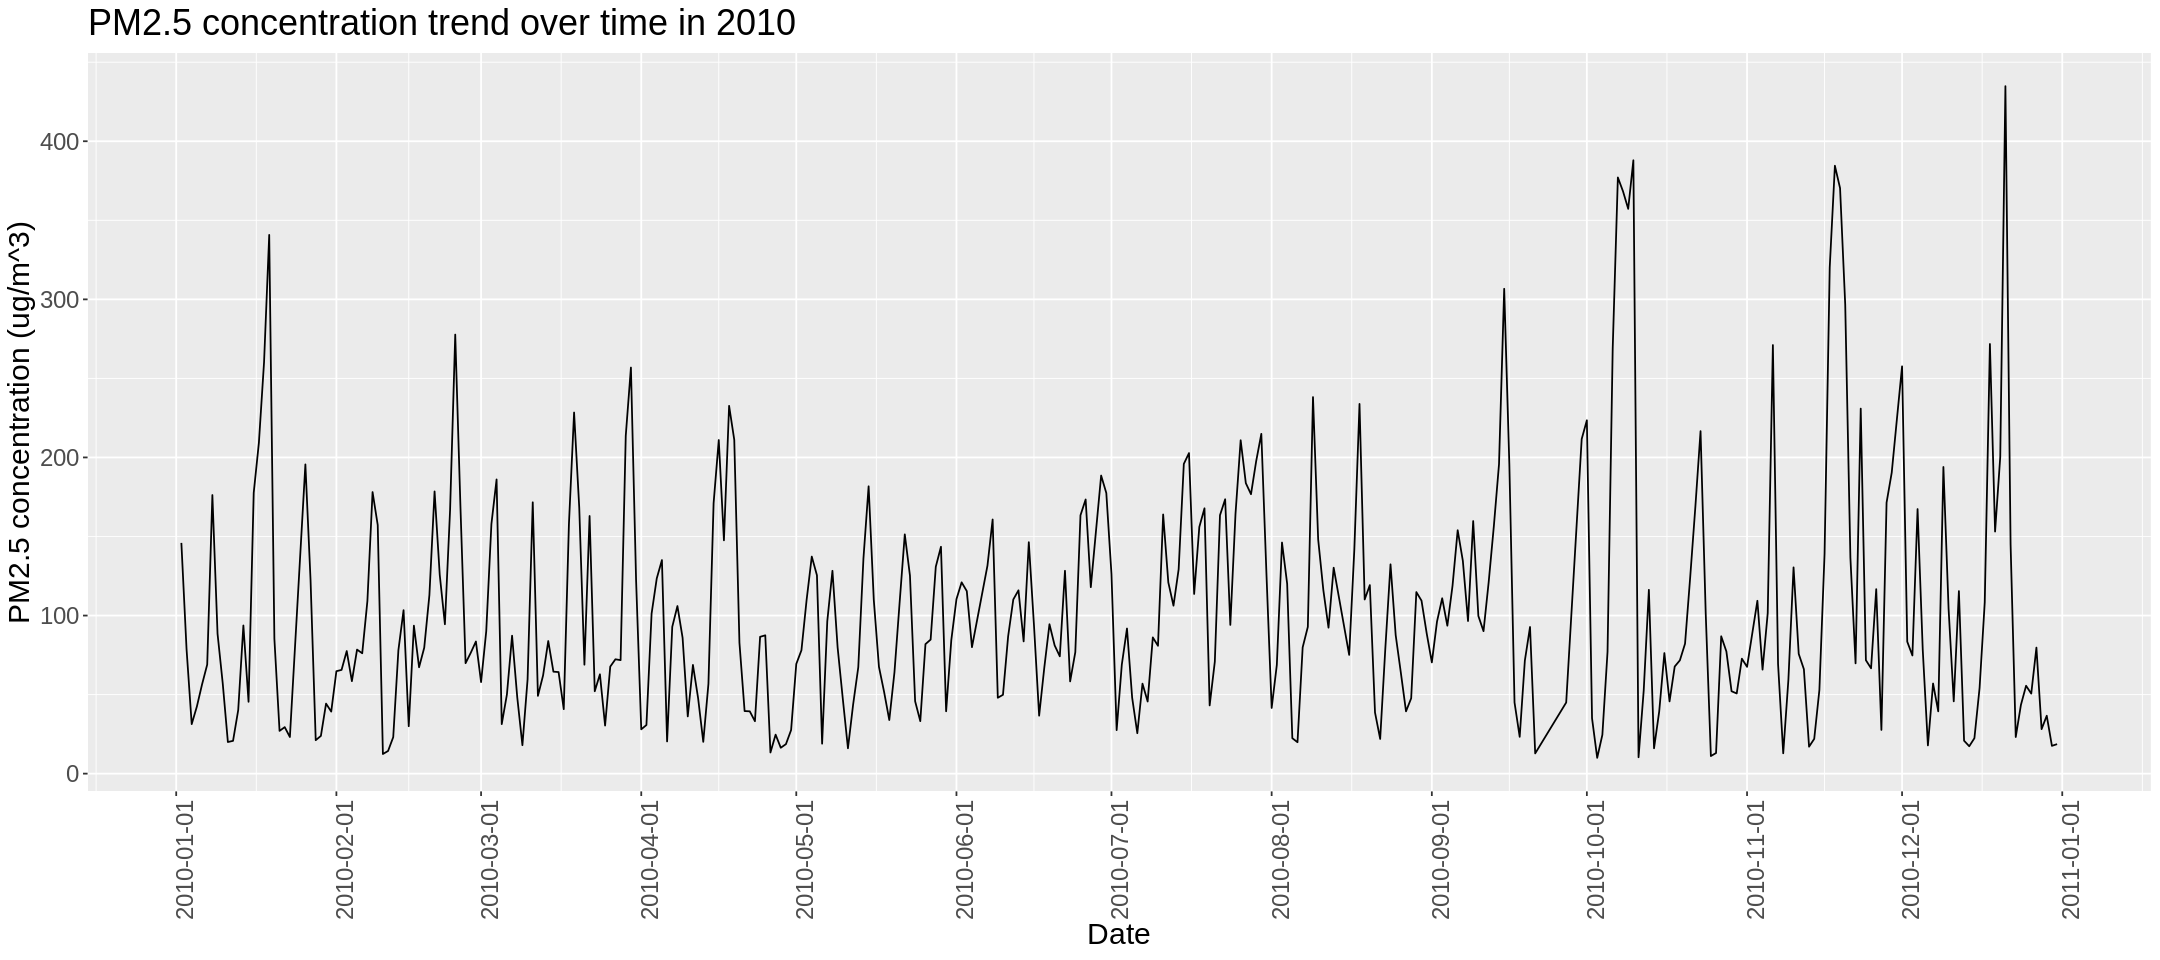

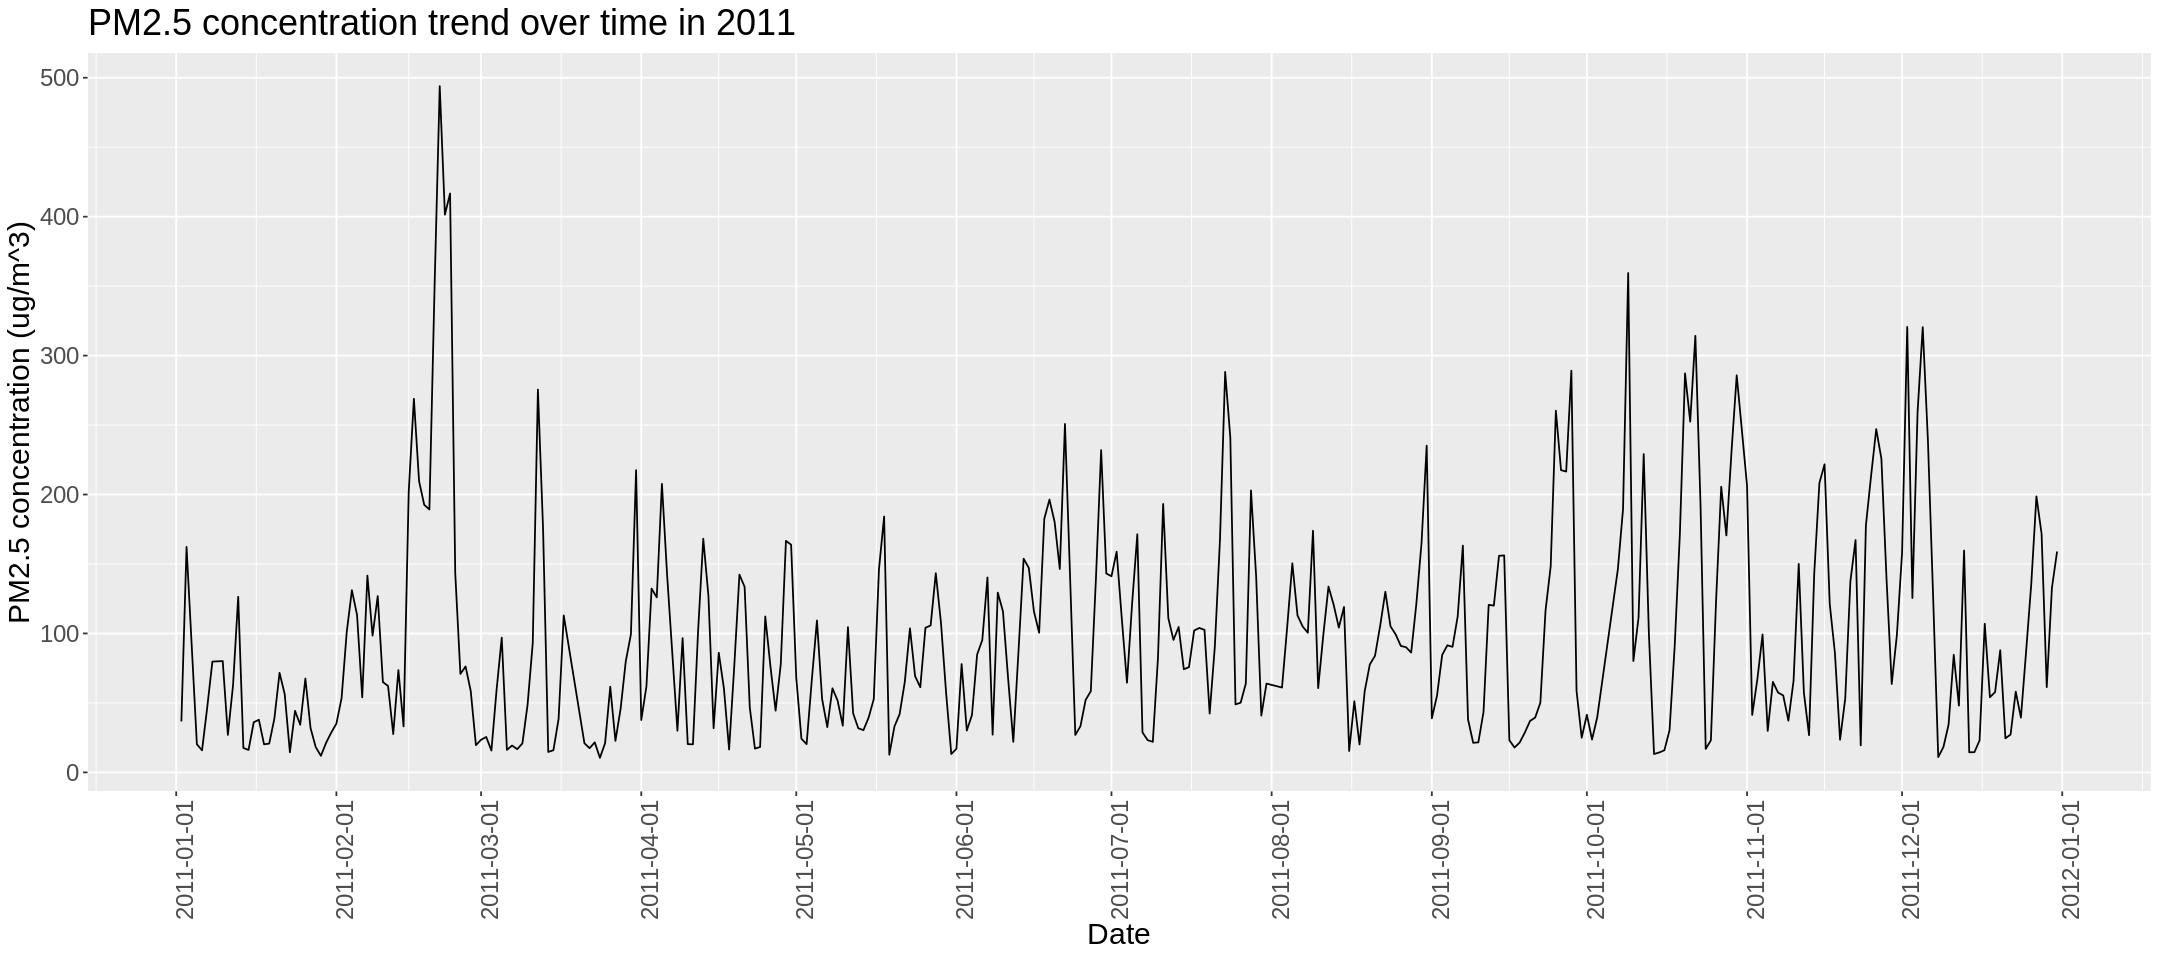

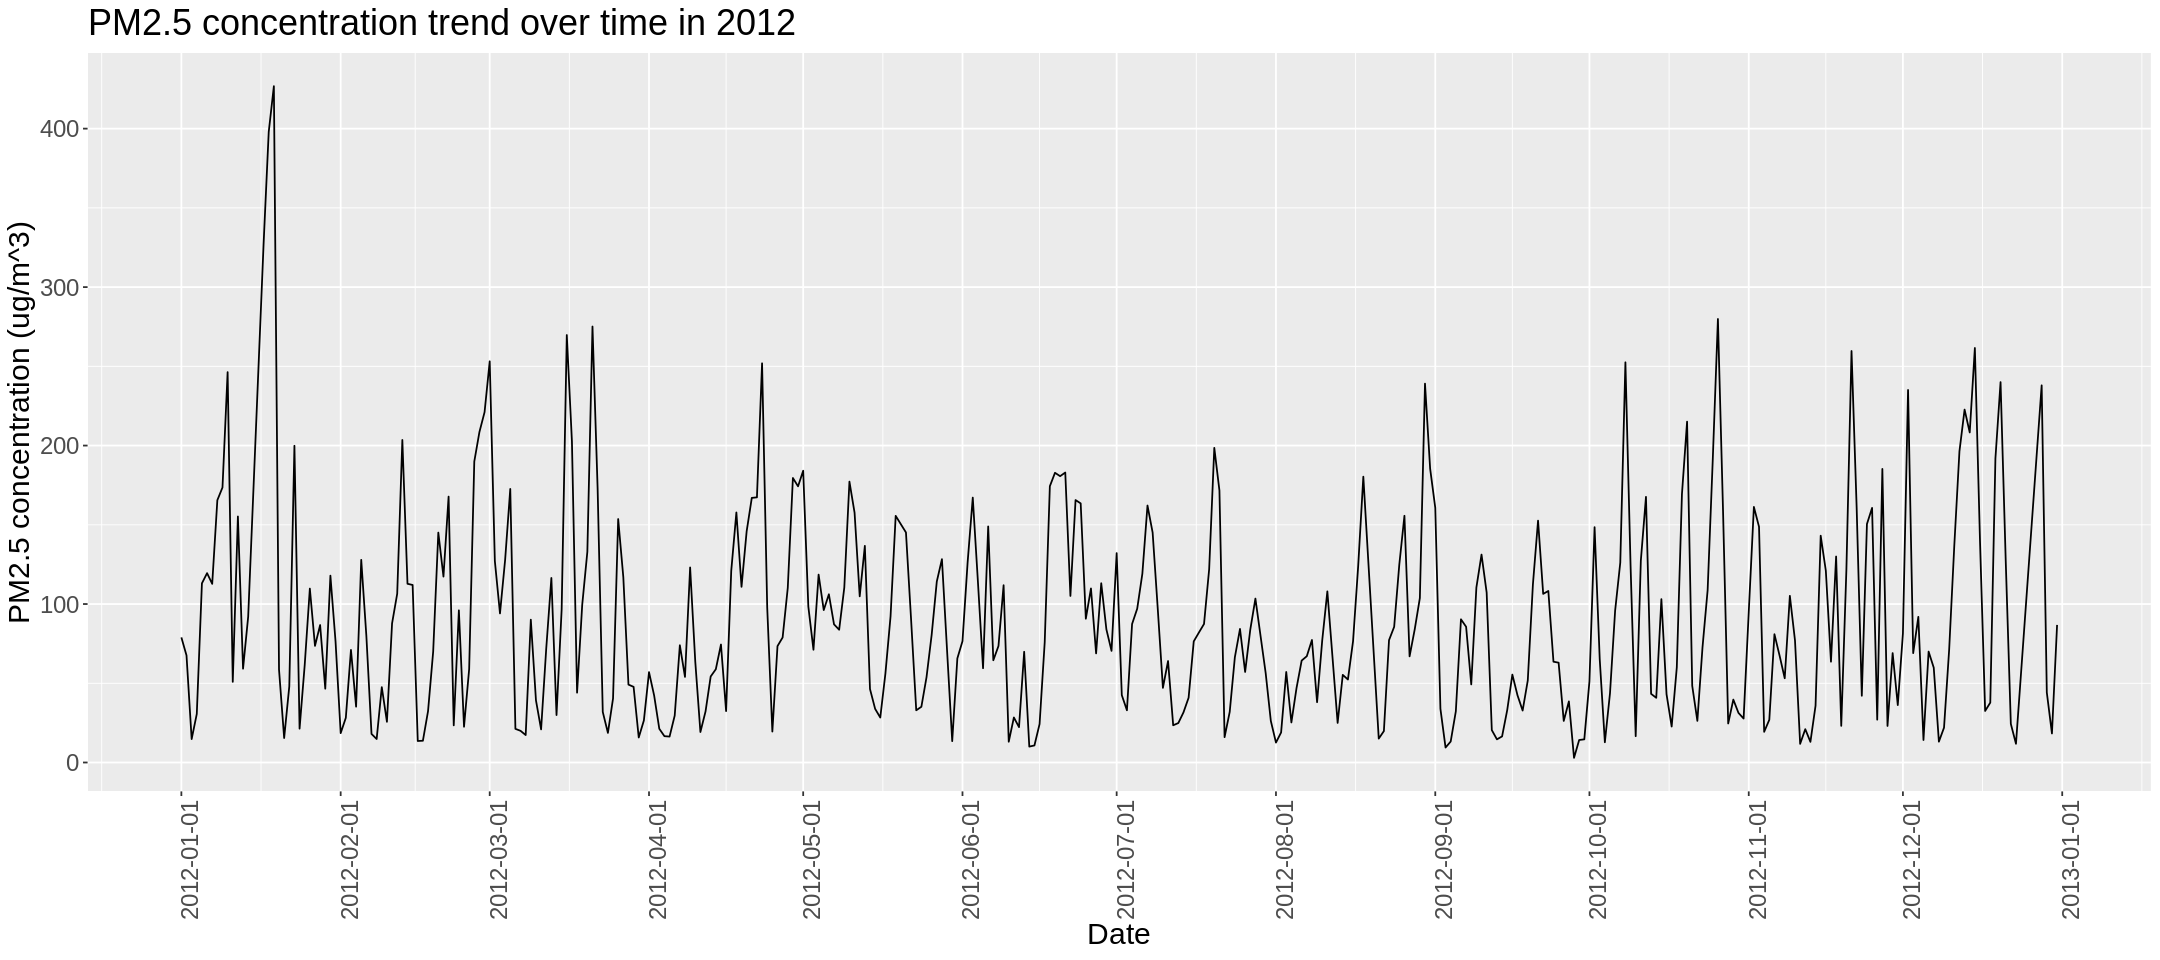

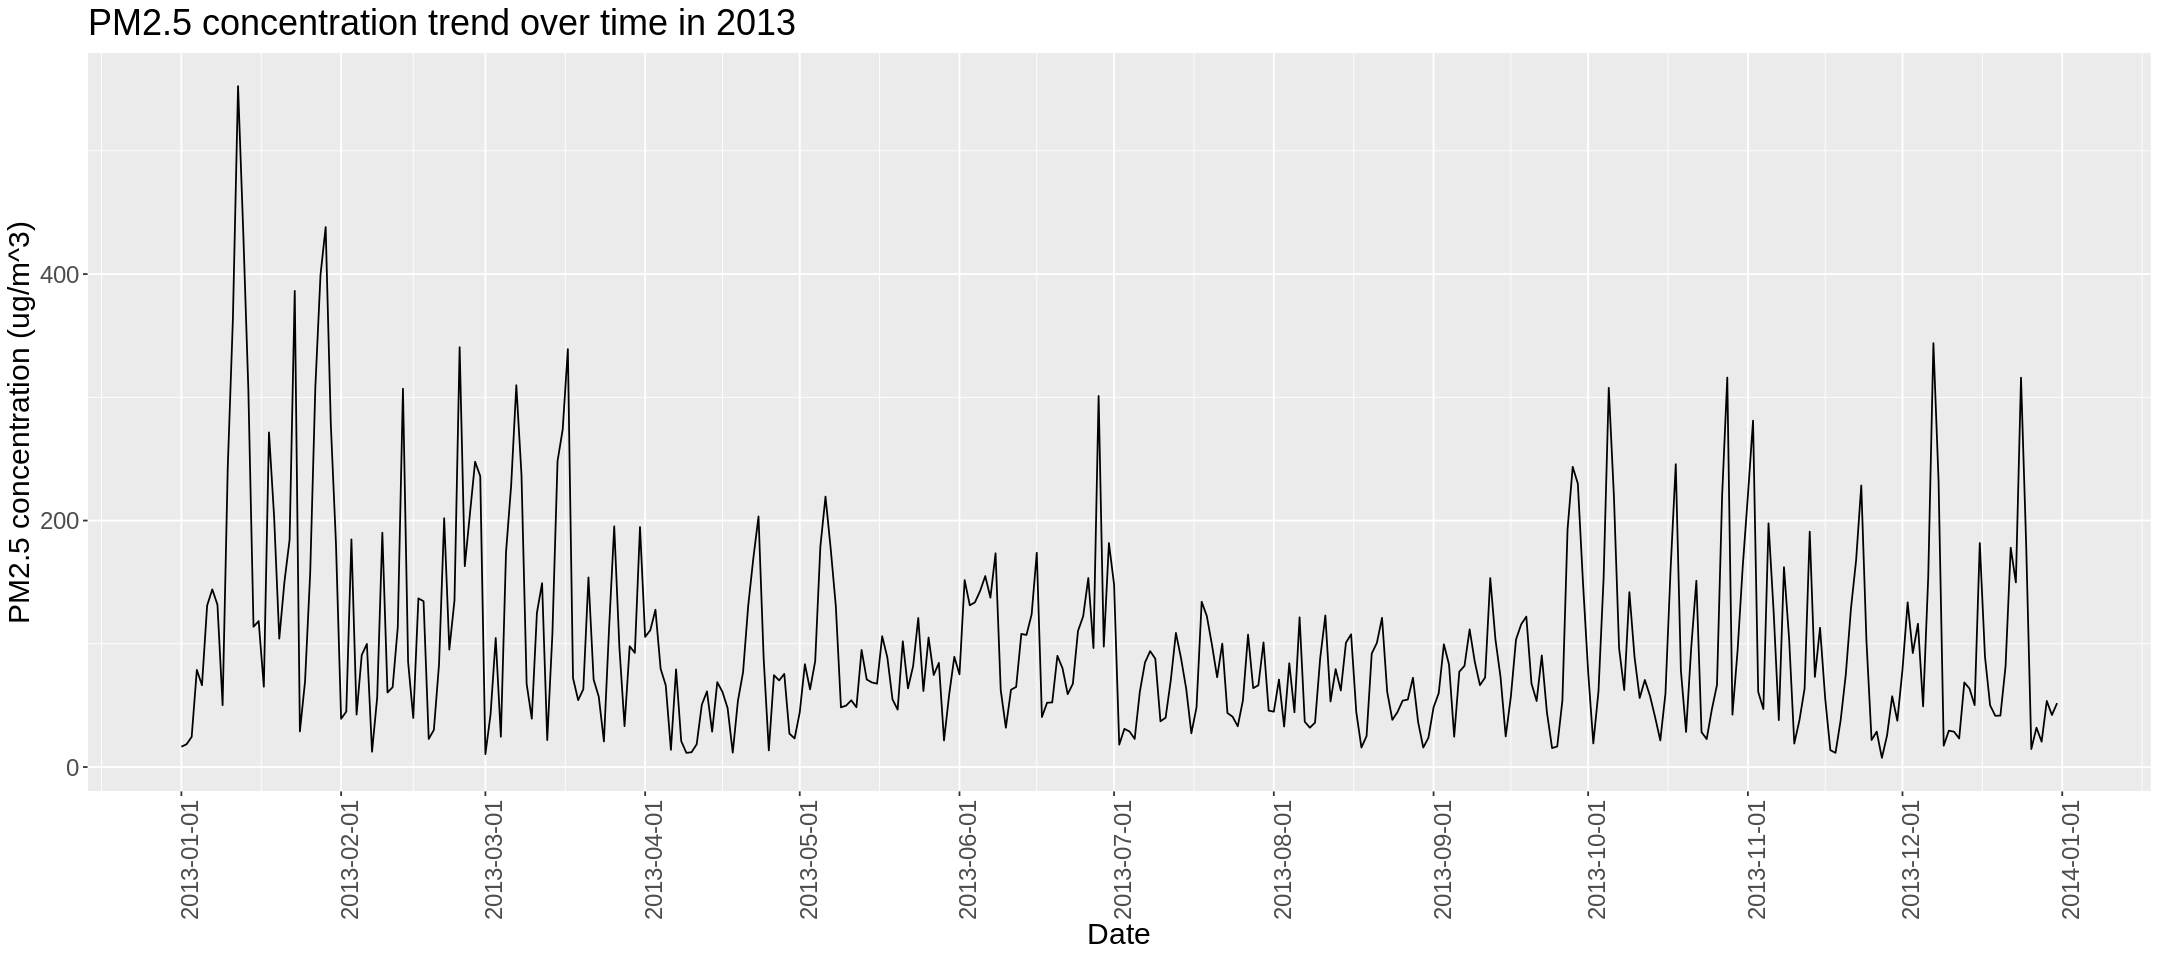

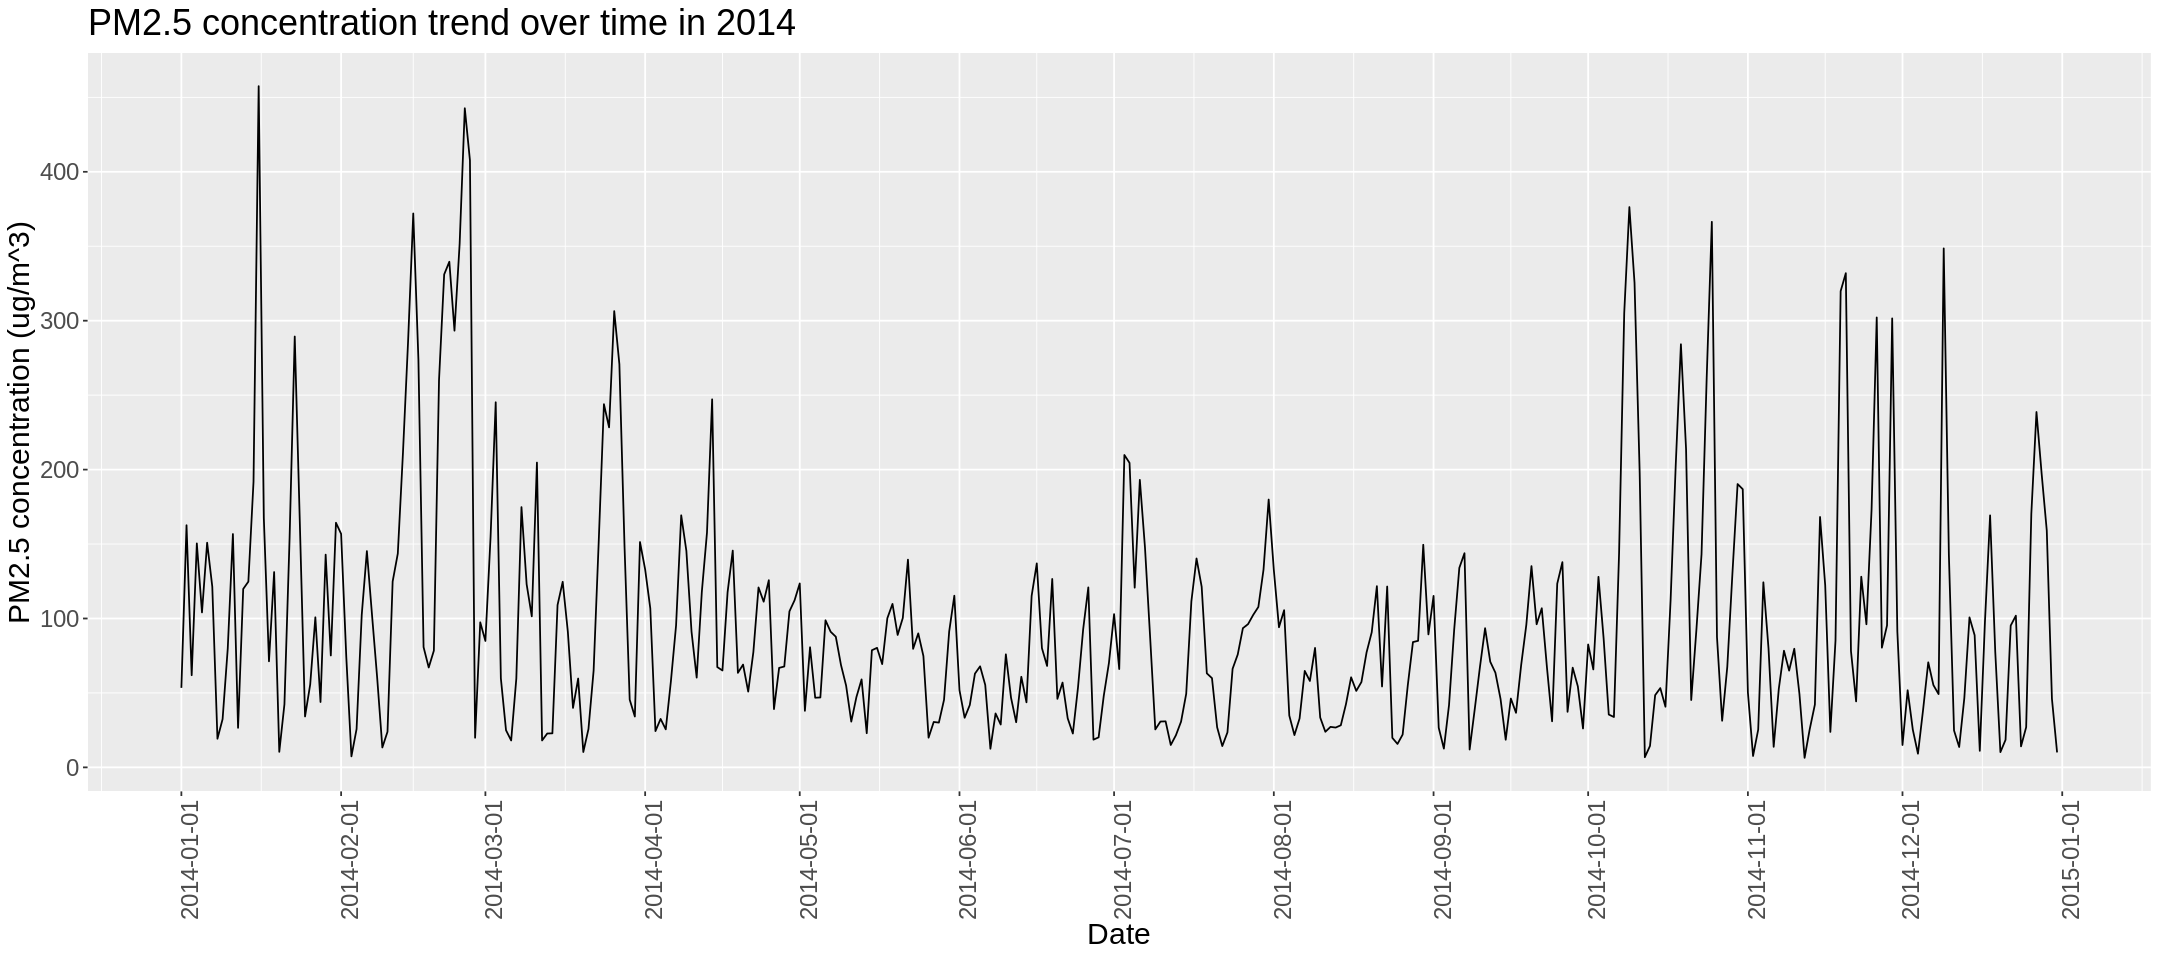

In [110]:
set.seed(9999)
options(repr.plot.width = 18, repr.plot.height = 8)
pm2.5_data <- pollution %>%
    select(year,month,day,pm2.5) %>%
    group_by(year,month,day) %>%
    summarise(pm2.5_avg = mean(pm2.5, na.rm = TRUE))
pm2.5_data$Date<-as.Date(with(pm2.5_data,paste(year,month,day,sep="-")),"%Y-%m-%d")

# pm2.5_monthly_plot <- pollute_avg %>%
#     select(year,month,pm2.5_avg) %>%
#     group_by(year,month) %>%
#     summarise(pm2.5_avg = mean(pm2.5_avg, na.rm = TRUE))
# pm2.5_data$Date<-as.Date(with(pm2.5_data,paste(year,month,sep="-")),"%Y-%m")


# pm2.5_time_total_plot <- ggplot(pm2.5_data, aes(x = Date, y = pm2.5_avg)) + 
#      geom_line() +
#      xlab("Date") +
#      ylab("PM2.5 concentration (ug/m^3)") + 
#     scale_x_date(date_breaks = "1 month") +
#     ggtitle("PM2.5 concentration trend over time from 2010 to 2014") +
#      theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
# pm2.5_time_total_plot

pm2.5_time_2010_plot <- pm2.5_data %>%
filter(year == 2010) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") + 
    ggtitle("PM2.5 concentration trend over time in 2010") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2010_plot

pm2.5_time_2011_plot <- pm2.5_data %>%
filter(year == 2011) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") + 
    ggtitle("PM2.5 concentration trend over time in 2011") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2011_plot

pm2.5_time_2012_plot <- pm2.5_data %>%
filter(year == 2012) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time in 2012") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2012_plot

pm2.5_time_2013_plot <- pm2.5_data %>%
filter(year == 2013) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
     ggtitle("PM2.5 concentration trend over time in 2013") +
    scale_x_date(date_breaks = "1 month") + # labels every month
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2013_plot

pm2.5_time_2014_plot <- pm2.5_data %>%
filter(year == 2014) %>%
ggplot(aes(x = Date, y = pm2.5_avg)) + 
     geom_line() +
     xlab("Date") +
     ylab("PM2.5 concentration (ug/m^3)") + 
    scale_x_date(date_breaks = "1 month") +
    ggtitle("PM2.5 concentration trend over time in 2014") +
     theme(axis.text.x = element_text(angle = 90, hjust = 1), text = element_text(size = 18)) 
pm2.5_time_2014_plot

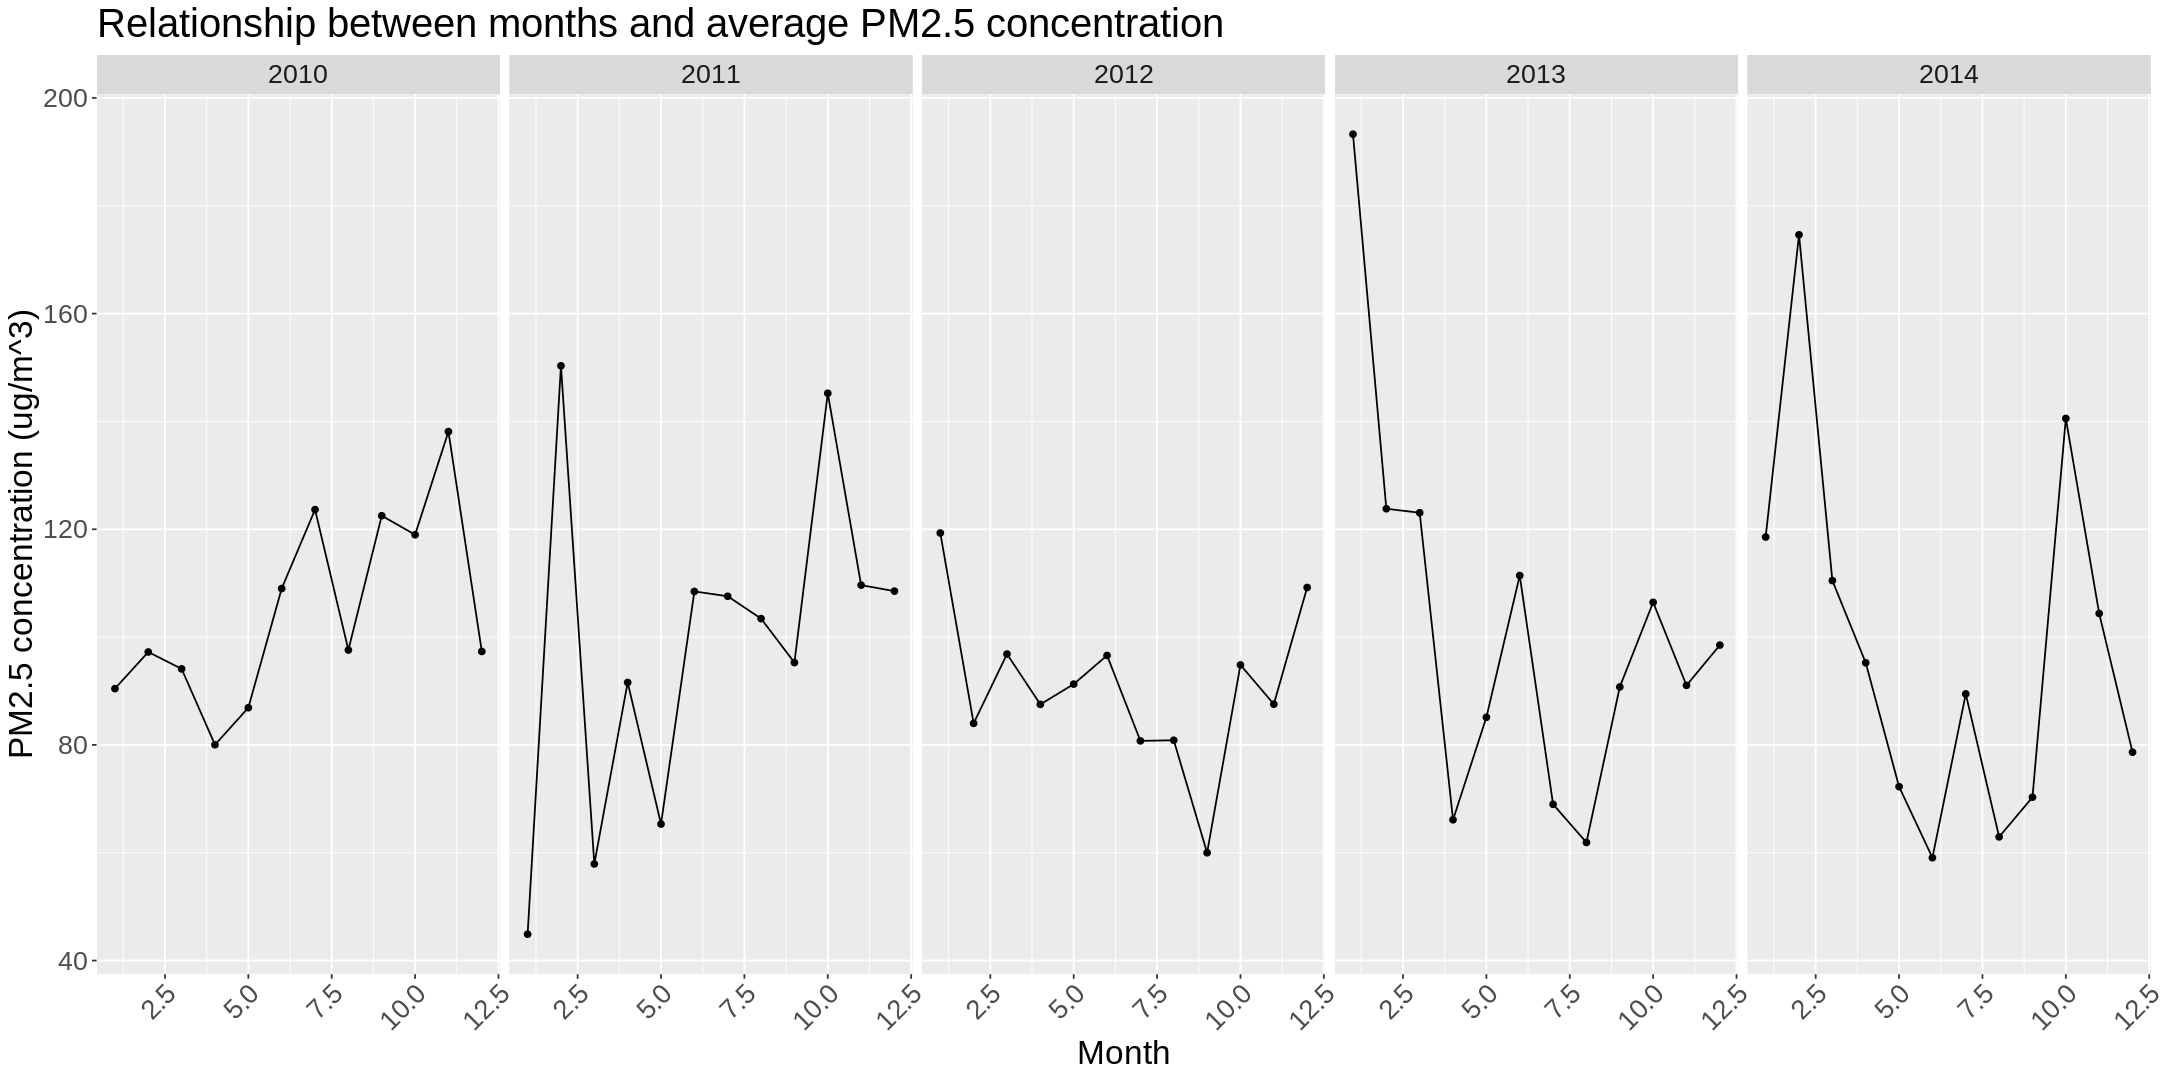

In [111]:
set.seed(9999)
options(repr.plot.width = 18, repr.plot.height = 9)
pm2.5_avg_plot <- pollute_avg %>%
    ggplot(aes(x = month, y = pm2.5_avg)) + 
    geom_line() +
    geom_point() +
    ggtitle("Relationship between months and average PM2.5 concentration") + 
    labs(x = "Month",y = "PM2.5 concentration (ug/m^3)") +
    facet_grid(.~ year) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         strip.text.y.left = element_text(angle = 0),
         text = element_text(size = 20))
pm2.5_avg_plot

The graphs do not show a clear periodical relationship between the months and PM2.5 concentration, but we tend to see that during the winter seasons (first and last few months of a year) that the concentration of PM2.5 either surge or drop more drastically compared to the summer months (middle months of a year). 

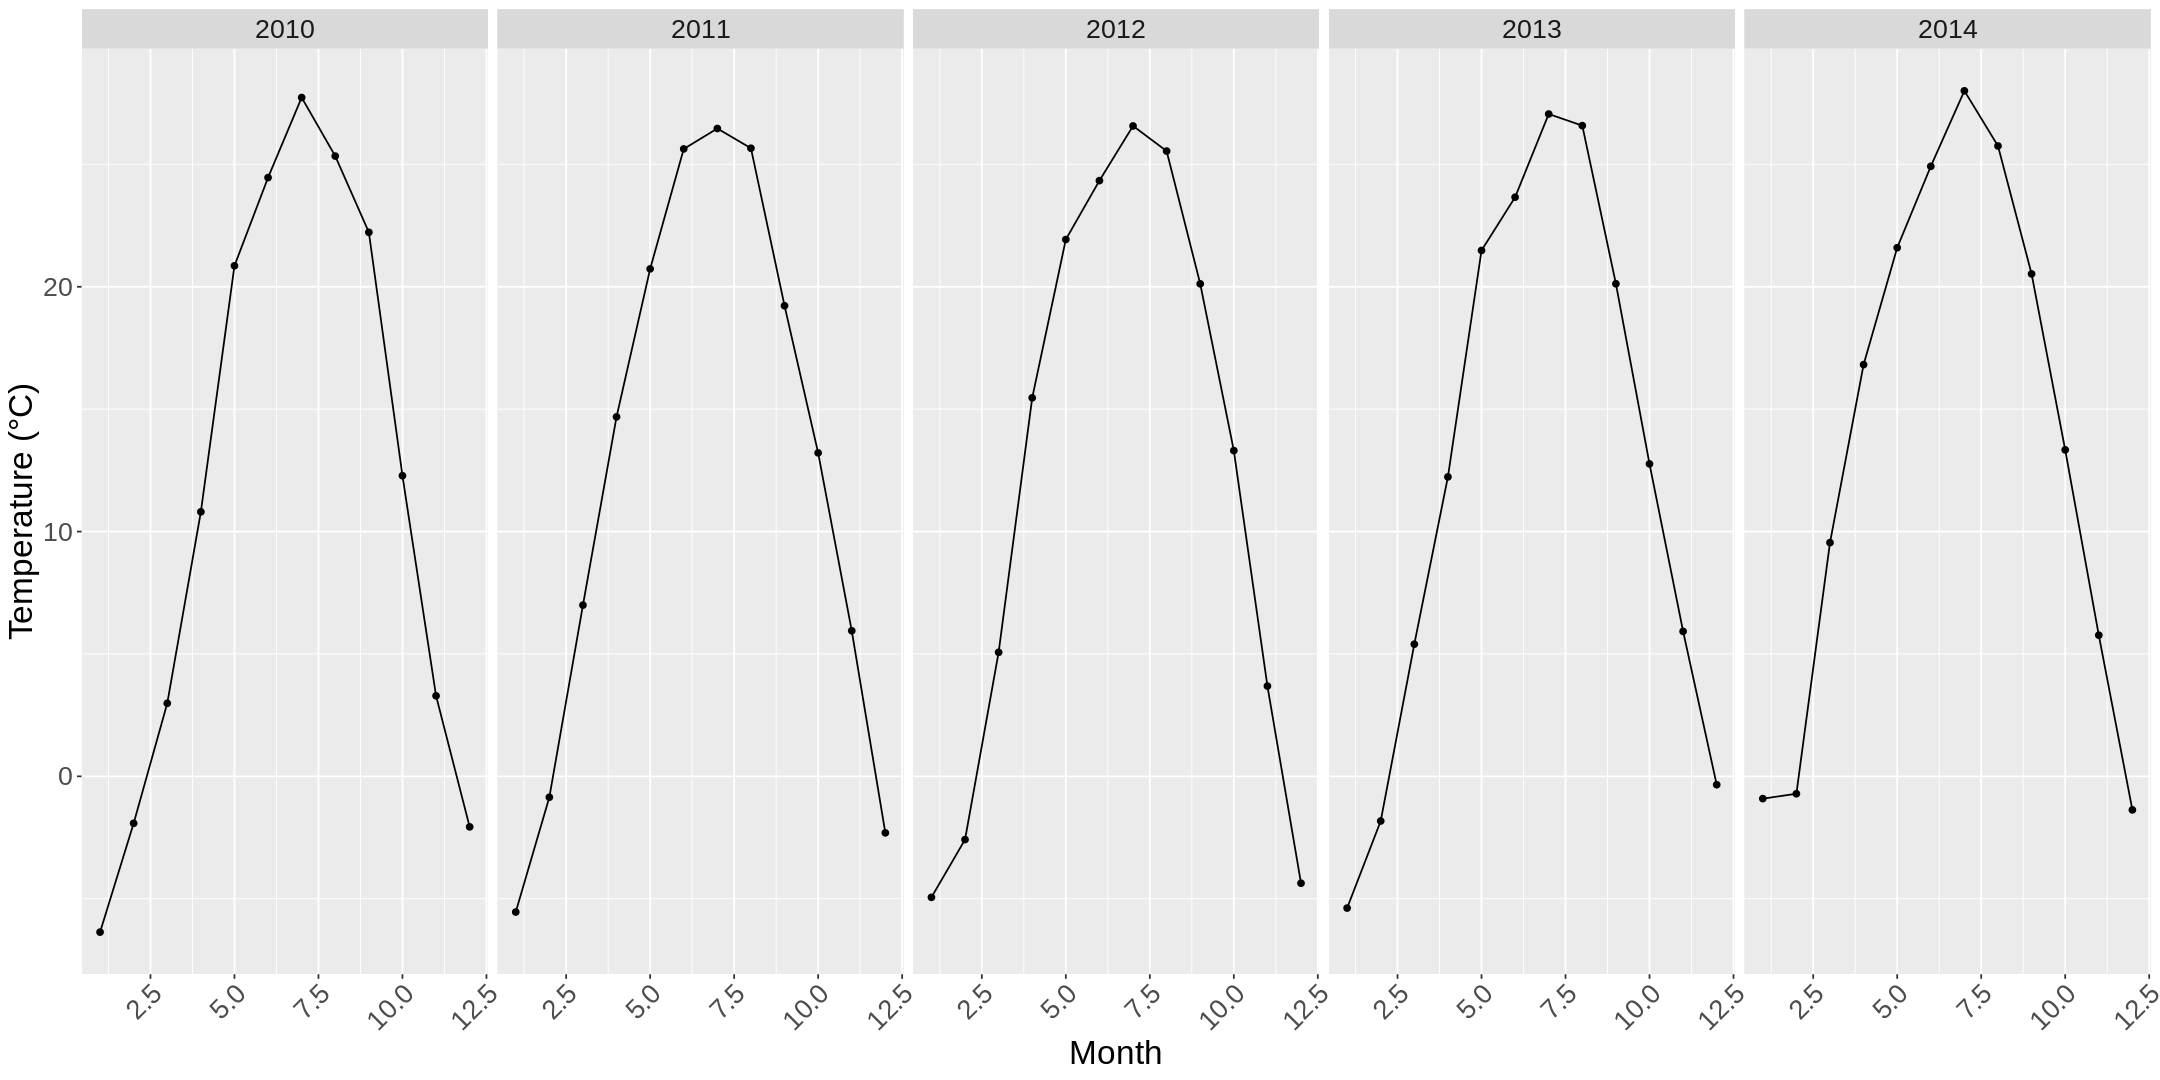

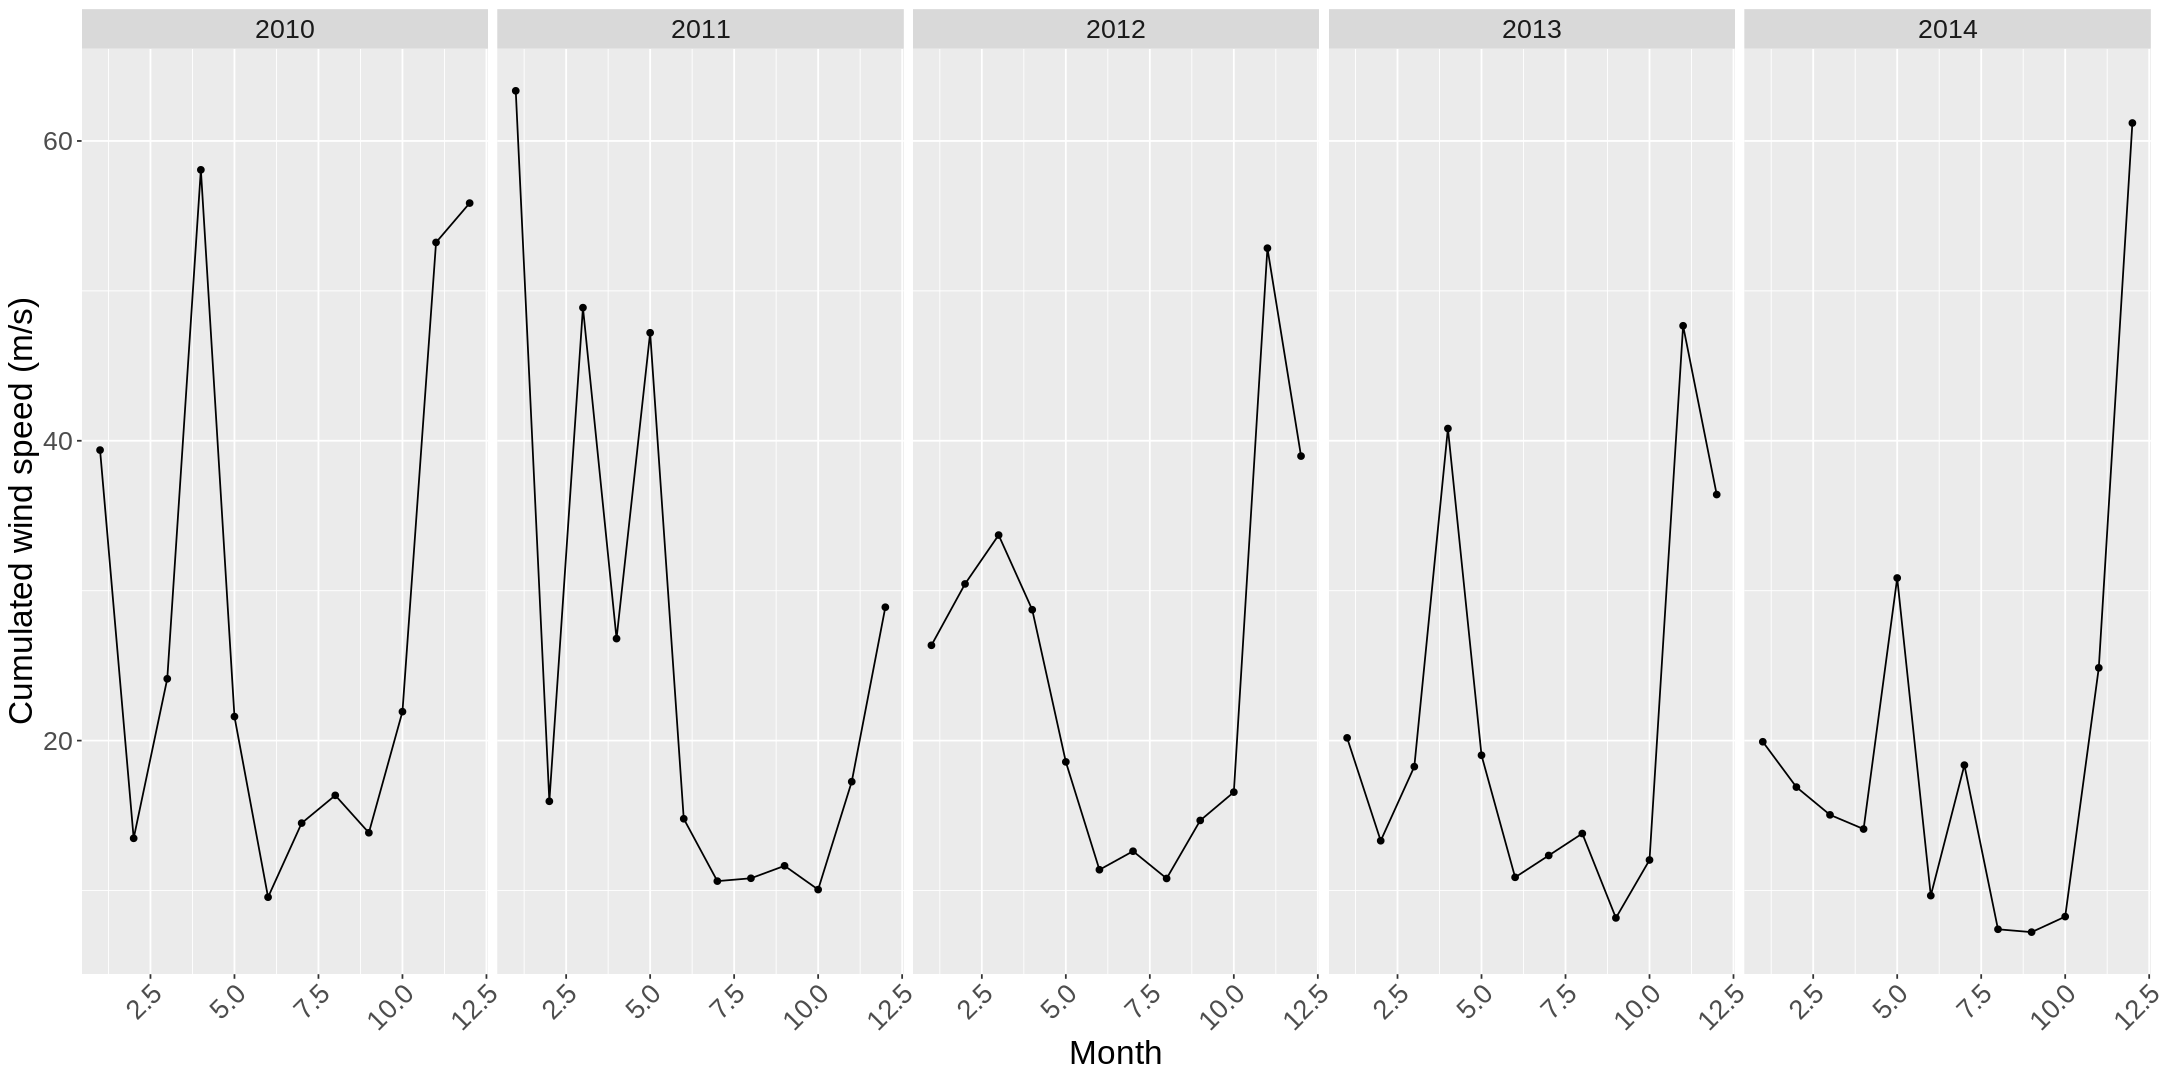

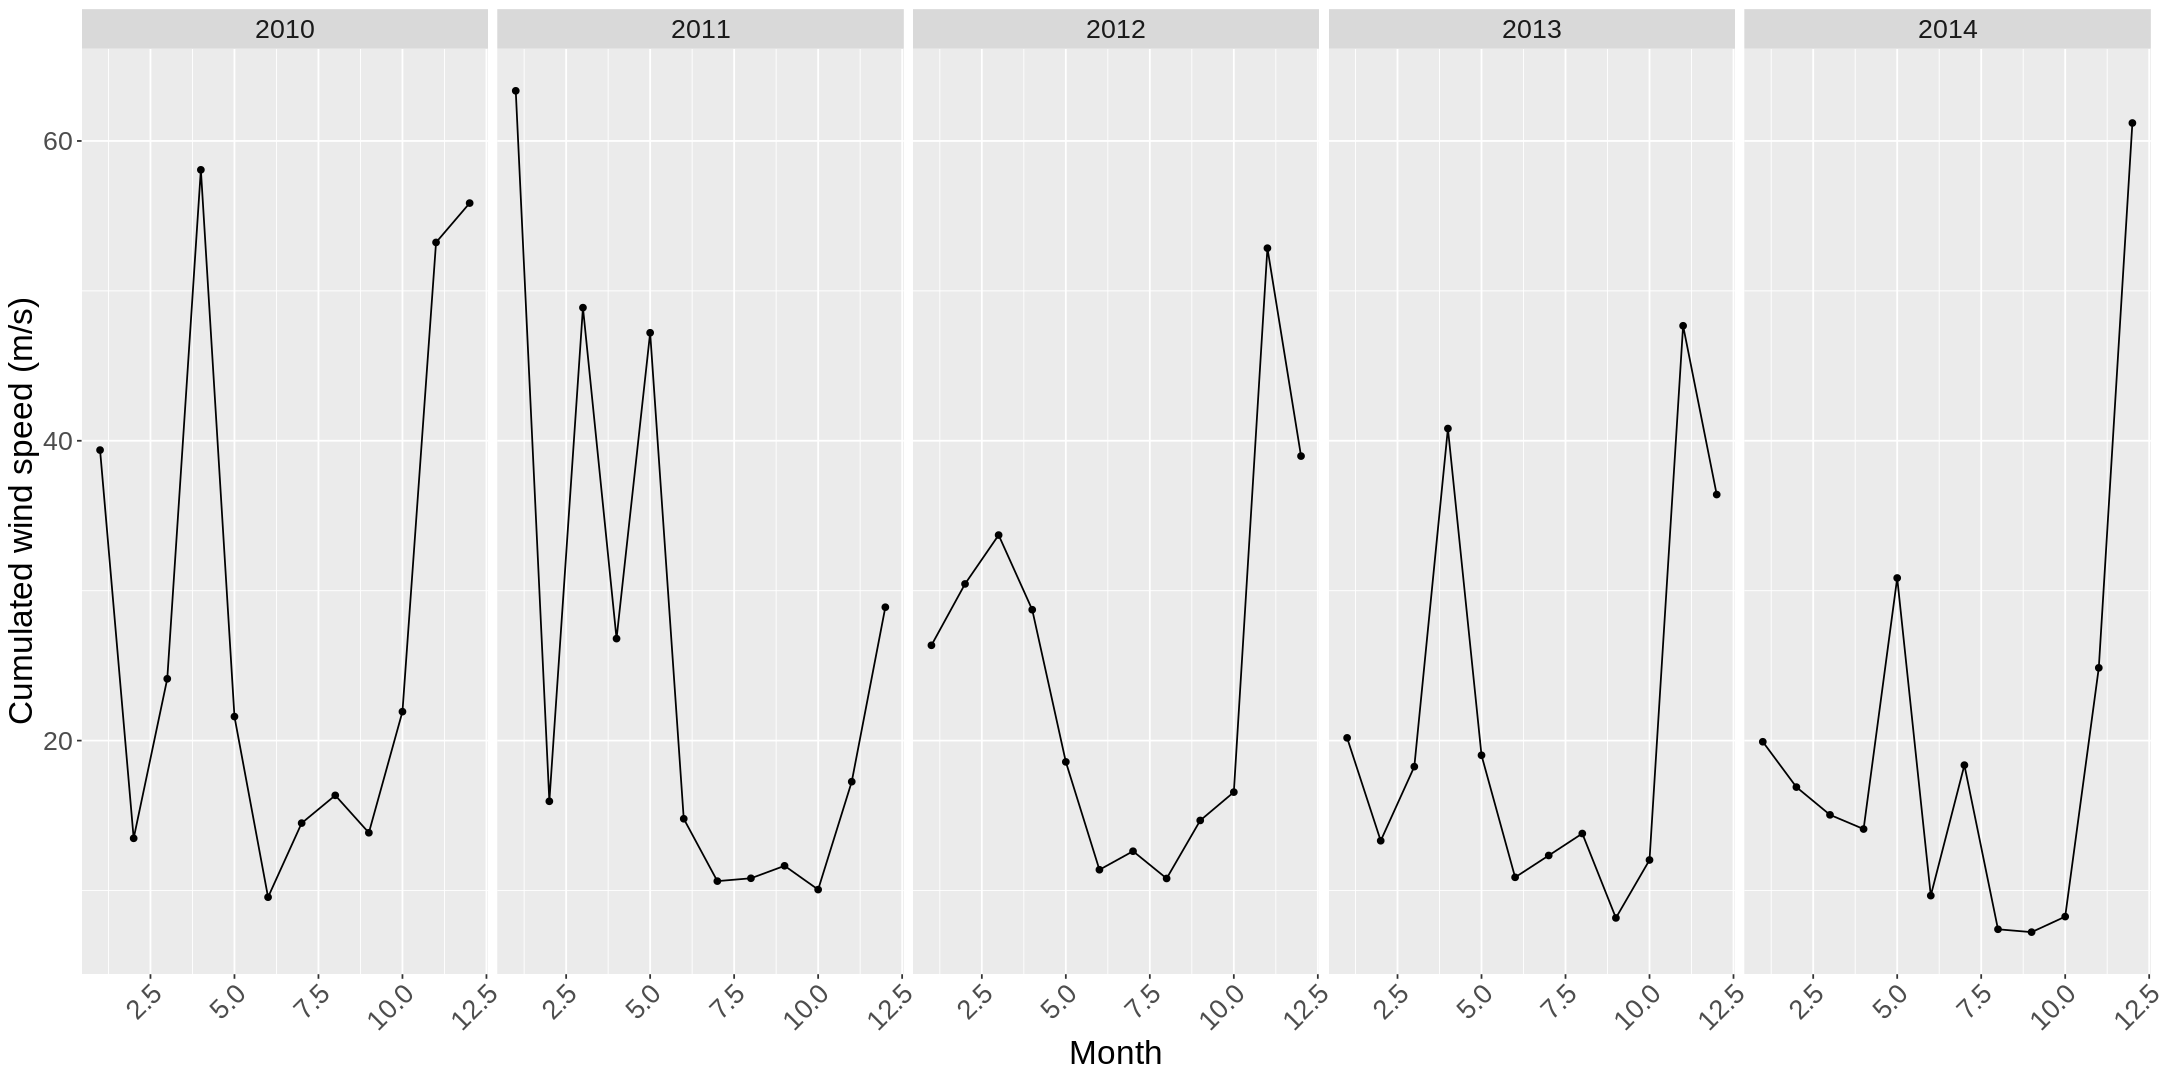

In [112]:
options(repr.plot.width = 18, repr.plot.height = 9)
TEMP_avg_plot <- pollute_avg %>%
    ggplot(aes(x = month, y = TEMP_avg)) + 
    geom_line() +
    geom_point() +
    xlab("Month") + 
    ylab("Temperature (°C)") +
    facet_grid(.~ year) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         strip.text.y.left = element_text(angle = 0),
         text = element_text(size = 20))
TEMP_avg_plot

Iws_avg_plot <- pollute_avg %>%
    ggplot(aes(x = month, y = Iws_avg)) + 
    geom_line() +
    geom_point() +
    xlab("Month") + 
    ylab("Cumulated wind speed (m/s)") +
    facet_grid(.~ year) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         strip.text.y.left = element_text(angle = 0),
         text = element_text(size = 20))
Iws_avg_plot

HUMID_avg_plot <- pollute_avg %>%
    ggplot(aes(x = month, y = Iws_avg)) + 
    geom_line() +
    geom_point() +
    xlab("Month") + 
    ylab("Cumulated wind speed (m/s)") +
    facet_grid(.~ year) +
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
         strip.text.y.left = element_text(angle = 0),
         text = element_text(size = 20))
HUMID_avg_plot

## Conclusion
We expect to find the strength of the relationships between the three predictors and PM2.5 concentration.

Concluding from our previous visualizations, we find that:
- According to the graphs for TEMP, there is a negative correlation between temperature and PM2.5. This is to be expected, as an increase in temperature will lead to an increase in Brownian motion of particles in the air, causing PM2.5 to be more dispersed.
- According to the graphs for Iws, there is a negative correlation between cumulated wind speed.
- According to the graphs for HUMID, there is a positive correlation between temperature and PM2.5. This is possible, as increasing the humidity will also lead to more particles being suspended in the air, increasing the concentration of PM2.5.

The three results suggest that when 1) the temperature is relatively high, 2) the cumulated wind speed is relatively high, and 3) the humidity is relatively low, the conditions may be more appropriate for residents in Beijing to engage in outdoor activities (e.g. hiking) without risking respiratory diseases.

Our findings will provide good suggestions for whether residents in Beijing can do outdoor activities under different conditions. However, one further question that we want to ask is whether different locations in Beijing lead to different PM 2.5 concentrations. Other factors that could affect PM2.5 concentration that should also be accounted for are air pressure and rainfall. The question is expected to be answered in the future as we do not have location data in our current dataset, nor do we have sufficient data to account for other potential factors.

## Citations:
- “California Air Resources Board.” Inhalable Particulate Matter and Health (PM2.5 and PM10) | California Air Resources Board, https://ww2.arb.ca.gov/resources/inhalable-particulate-matter-and-health#:~:text=For%20PM2.,symptoms%2C%20and%20restricted%20activity%20days.
- Liang, X., Zou, T., Guo, B., Li, S., Zhang, H., Zhang, S., Huang, H. and Chen, S. X. (2015). Assessing Beijing's PM2.5 pollution: severity, weather impact, APEC and winter heating. Proceedings of the Royal Society A, 471, 20150257.
- Sun, Ruiling, et al. “Influencing Factors of PM2.5 Pollution: Disaster Points of Meteorological Factors.” International Journal of Environmental Research and Public Health, MDPI, 14 Oct. 2019, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6843796/.
- S;, Wang J;Ogawa. “Effects of Meteorological Conditions on PM2.5 Concentrations in Nagasaki, Japan.” International Journal of Environmental Research and Public Health, U.S. National Library of Medicine, https://pubmed.ncbi.nlm.nih.gov/26247953/#:~:text=Nagasaki%20is%20a%20coastal%20prefecture,transport%20and%20correlation%20between%20PM2.&text=5%20concentration%20and%20meteorological%20data,5.
- X Li al 2017 IOP Conf. Ser,: Earth Environ. Sci. 78 012003